In [1]:
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
import numpy as np
import os
import pandas as pd
import seaborn as sns

from benchmarks import gsa_svm_fitness
from src.entities import GSA

from IPython.display import display
from matplotlib import pyplot as plt
from scipy import stats as st
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from typing import Mapping, Tuple, Union
from ucimlrepo import fetch_ucirepo

In [2]:
uci_datasets = ["Breast Cancer Wisconsin (Diagnostic)",
                "Spambase",
                "Mushroom"]

widget_opt = widgets.Dropdown(options=uci_datasets,
                              description='Dataset: ')

display(widget_opt)

Dropdown(description='Dataset: ', options=('Breast Cancer Wisconsin (Diagnostic)', 'Spambase', 'Mushroom'), va…

In [14]:
def fetch_uci_dataset(dataset_name: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Fetch UCI dataset
    """
    def fetch_categorical_dataset(_id: int) -> Tuple[pd.DataFrame, pd.Series]:
        data = fetch_ucirepo(id=_id)
        X = data.data.features
        y = data.data.targets
        encoder = LabelEncoder()
        for col in X.columns:
            X.loc[:, col] = encoder.fit_transform(X[col])
        return X, y

    if dataset_name == "Breast Cancer Wisconsin (Diagnostic)":
        data = fetch_ucirepo(id=15)
        X = data.data.features
        y = data.data.targets
        X = X.fillna(value=0)
    elif dataset_name == "Spambase":
        X, y = fetch_categorical_dataset(_id=94)
    elif dataset_name == "Mushroom":
        X, y = fetch_categorical_dataset(_id=73)
    
    return X, y

X, y = fetch_uci_dataset(widget_opt.value)

# Name of selected dataset and summary (number of instances, features, etc.)
print(f"Dataset: {widget_opt.value}")
print(f"Instances: {X.shape[0]}")
print(f"Features: {X.shape[1]}")

Dataset: Mushroom
Instances: 8124
Features: 22


In [15]:
# WARNING!! GLOBAL VARIABLES
wa = 0.0
wf = 0.0

# IMPORTANT!! MUTABLE GLOBAL VARIABLE
conf_matrix_dict = {"TP": 0, "FP": 0, "TN": 0, "FN": 0}

class UCI:
    """
    Class to handle UCI datasets
    
    Args:
        X (pd.DataFrame): Features
        y (pd.Series): Target
    """
    def __init__(self,
                 X: pd.DataFrame,
                 y: pd.Series,
                 boundaries: Mapping[str, Tuple[Tuple[float, float], ...]],
                 seed: int=5
                 ) -> None:
        """
        Constructor
        
        Args:
            X (pd.DataFrame): Features
            y (pd.Series): Target
            boundaries (Mapping[str, Tuple[Tuple[float, float], ...]): Boundaries for the optimization problem
            seed (int, optional): Random seed. Defaults to 5.
        """
        self.X = X
        self.y = y
        self.boundaries = boundaries

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)
        
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    
    def get_fitness(self,
                    solution: Mapping[str, np.ndarray],
                    data: Union[None, Tuple[np.ndarray, np.ndarray]] = None,
                    show_confusion_matrix: bool=False
                    ) -> Tuple[float, float]:
        """
        Get fitness of a solution
        
        Args:
            solution (Mapping[str, np.ndarray]): Solution to evaluate
            data (Union[None, Tuple[np.ndarray, np.ndarray]], optional): Data to evaluate the solution. Defaults to None.
        
        Returns:
            Tuple[float, float]: Fitness and accuracy of the solution    
        """
        if data is None:
            X_scaled = self.X_train
            y_data = self.y_train
        else:
            X_scaled, y_data = data
            
        gamma, C = solution['real']
        gamma /= 1_000
        C /= 1_000
        X_scaled_filtered = X_scaled[:, solution['discrete'].astype(int) == 1]
        svc_model = SVC(gamma=gamma, C=C, kernel="rbf", verbose=False)
        svc_model.fit(X_scaled_filtered, np.ravel(y_data))
        y_predict = svc_model.predict(X_scaled_filtered)
        conf_matrix = confusion_matrix(y_data, y_predict)
        if show_confusion_matrix:
            # Update global conf_matrix_dict
            conf_matrix_dict["TP"] = conf_matrix[0, 0]
            conf_matrix_dict["FP"] = conf_matrix[0, 1]
            conf_matrix_dict["TN"] = conf_matrix[1, 1]
            conf_matrix_dict["FN"] = conf_matrix[1, 0]
            print(conf_matrix)
        accuracy = accuracy_score(y_data, y_predict) * 100
        
        return gsa_svm_fitness(accuracy=accuracy, solution=solution, wa=wa, wf=wf)

    def is_feasible(self, solution: Mapping[str, np.ndarray]) -> bool:
        """
        Check if a solution is feasible

        Args:
            solution (Mapping[str, np.ndarray]): Solution to evaluate

        Returns:
            bool: True if the solution is feasible, False otherwise
        """
        real_values = solution['real']
        discrete_values = solution['discrete']

        for i, (min_val, max_val) in enumerate(self.boundaries['real']):
            if real_values[i] < min_val or real_values[i] > max_val:
                return False

        for i, (min_val, max_val) in enumerate(self.boundaries['discrete']):
            if discrete_values[i] < min_val or discrete_values[i] > max_val:
                return False
        
        if sum(discrete_values) == 0:
            return False
        
        return True

boundaries = {'real': [(1, 100_000), (1, 100_000)], 'discrete': [(0, 1) for _ in range(len(X.columns))]}
uci_data = UCI(X, y, boundaries)

In [16]:
def run_gsa(chaotic_constant: bool=False,
            repair_solution: bool=False,
            runs: int=10,
            population_size: int=5,
            iterations: int=20
            ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    global_train_hist = pd.DataFrame()
    global_test_hist = pd.DataFrame(columns=["run", "accuracy", "fitness", "TP", "FP", "TN", "FN"])
    
    for k in range(runs):
        uci_data = UCI(X, y, boundaries)
        
        gsa_algo = GSA(objective_function = uci_data.get_fitness,
                       is_feasible=uci_data.is_feasible,
                       r_dim=2,
                       d_dim=len(X.columns),
                       boundaries=uci_data.boundaries)
        
        train_X_data = np.array_split(uci_data.X_train, population_size, axis=0)
        train_y_data = np.array_split(uci_data.y_train, population_size, axis=0)
        training_history = gsa_algo.optimize(train_data=(train_X_data, train_y_data),
                                             population_size=population_size,
                                             iters=iterations,
                                             chaotic_constant=chaotic_constant,
                                             repair_solution=repair_solution)
        
        training_history.insert(0, "run", k)
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        print(gsa_algo.solution_history[-1])
        fitness, accuracy = uci_data.get_fitness(solution=gsa_algo.solution_history[-1],
                                            data=(uci_data.X_test, uci_data.y_test),
                                            show_confusion_matrix=True)
        
        global_test_hist.loc[len(global_test_hist)] = [k, accuracy, fitness, conf_matrix_dict["TP"], conf_matrix_dict["FP"], conf_matrix_dict["TN"], conf_matrix_dict["FN"]]
        
        print("Test accuracy: ", accuracy, " - Fitness: ", fitness)
    
    return global_train_hist, global_test_hist

In [17]:
wa = 0.8
wf = 0.2
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for chaotic_constant in [True, False]:
    print(f"Running GSA with chaotic constant: ", chaotic_constant)
    tr_df, tt_df = run_gsa(chaotic_constant=chaotic_constant,
                           runs=10,
                           population_size=5,
                           iterations=20)
    
    tr_df["chaotic_constant"] = chaotic_constant
    tt_df["chaotic_constant"] = chaotic_constant
    train_df = pd.concat([train_df, tr_df], axis=0)
    test_df = pd.concat([test_df, tt_df], axis=0)

Running GSA with chaotic constant:  True
GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 90.9090909090909']


/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 90.9090909090909']
['At iteration 3 the best fitness is 90.9090909090909']
['At iteration 4 the best fitness is 90.9090909090909']
['At iteration 5 the best fitness is 90.9090909090909']
['At iteration 6 the best fitness is 90.9090909090909']
['At iteration 7 the best fitness is 90.9090909090909']
['At iteration 8 the best fitness is 91.81818181818181']
['At iteration 9 the best fitness is 91.81818181818181']
['At iteration 10 the best fitness is 91.81818181818181']
['At iteration 11 the best fitness is 91.81818181818181']
['At iteration 12 the best fitness is 92.2965034965035']
['At iteration 13 the best fitness is 93.80699300699301']
['At iteration 14 the best fitness is 93.80699300699301']
['At iteration 15 the best fitness is 93.80699300699301']
['At iteration 16 the best fitness is 93.80699300699301']
['At iteration 17 the best fitness is 93.80699300699301']
['At iteration 18 the best fitness is 93.80699300699301']
['At iteration 19 the best fi

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.0']
['At iteration 2 the best fitness is 91.75664335664335']
['At iteration 3 the best fitness is 91.75664335664335']
['At iteration 4 the best fitness is 91.75664335664335']
['At iteration 5 the best fitness is 91.75664335664335']
['At iteration 6 the best fitness is 91.75664335664335']
['At iteration 7 the best fitness is 91.75664335664335']
['At iteration 8 the best fitness is 91.75664335664335']
['At iteration 9 the best fitness is 91.75664335664335']
['At iteration 10 the best fitness is 91.75664335664335']
['At iteration 11 the best fitness is 91.75664335664335']
['At iteration 12 the best fitness is 91.75664335664335']
['At iteration 13 the best fitness is 92.72727272727272']
['At iteration 14 the best fitness is 94.48391608391609']
['At iteration 15 the best fitness is 94.48391608391609']
['At iteration 16 the best fitness is 94.48391608391609']
['At iteration 17 the best fitness is 94.48391608391609']
['At iteration 18 the best fitness i

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 91.81818181818181']
['At iteration 2 the best fitness is 92.72727272727272']
['At iteration 3 the best fitness is 92.72727272727272']
['At iteration 4 the best fitness is 92.72727272727272']
['At iteration 5 the best fitness is 92.72727272727272']
['At iteration 6 the best fitness is 93.2668486248163']
['At iteration 7 the best fitness is 93.2668486248163']
['At iteration 8 the best fitness is 93.2668486248163']
['At iteration 9 the best fitness is 93.2668486248163']
['At iteration 10 the best fitness is 93.86801035761776']
['At iteration 11 the best fitness is 93.86801035761776']
['At iteration 12 the best fitness is 94.88557631744699']
['At iteration 13 the best fitness is 95.14685314685315']
['At iteration 14 the best fitness is 95.14685314685315']
['At iteration 15 the best fitness is 95.14685314685315']
['At iteration 16 the best fitness is 95.14685314685315']
['At iteration 17 the best fitness is 95.14685314685315']
['At iteration 18 the best 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.0']
['At iteration 2 the best fitness is 92.60419580419583']
['At iteration 3 the best fitness is 92.60419580419583']
['At iteration 4 the best fitness is 92.8979020979021']
['At iteration 5 the best fitness is 92.8979020979021']
['At iteration 6 the best fitness is 92.8979020979021']
['At iteration 7 the best fitness is 92.8979020979021']
['At iteration 8 the best fitness is 92.8979020979021']
['At iteration 9 the best fitness is 94.42237762237764']
['At iteration 10 the best fitness is 94.42237762237764']
['At iteration 11 the best fitness is 94.42237762237764']
['At iteration 12 the best fitness is 94.42237762237764']
['At iteration 13 the best fitness is 94.42237762237764']
['At iteration 14 the best fitness is 94.42237762237764']
['At iteration 15 the best fitness is 94.42237762237764']
['At iteration 16 the best fitness is 94.42237762237764']
['At iteration 17 the best fitness is 94.42237762237764']
['At iteration 18 the best fitness is 94.

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.35524475524475']
['At iteration 2 the best fitness is 91.96083916083917']
['At iteration 3 the best fitness is 91.96083916083917']
['At iteration 4 the best fitness is 92.54265734265735']
['At iteration 5 the best fitness is 92.54265734265735']
['At iteration 6 the best fitness is 92.54265734265735']
['At iteration 7 the best fitness is 92.54265734265735']
['At iteration 8 the best fitness is 92.66573426573427']
['At iteration 9 the best fitness is 92.66573426573427']
['At iteration 10 the best fitness is 92.66573426573427']
['At iteration 11 the best fitness is 92.72727272727272']
['At iteration 12 the best fitness is 92.72727272727272']
['At iteration 13 the best fitness is 92.72727272727272']
['At iteration 14 the best fitness is 92.72727272727272']
['At iteration 15 the best fitness is 93.63636363636364']
['At iteration 16 the best fitness is 93.63636363636364']
['At iteration 17 the best fitness is 93.63636363636364']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 91.75664335664335']
['At iteration 3 the best fitness is 91.75664335664335']
['At iteration 4 the best fitness is 91.75664335664335']
['At iteration 5 the best fitness is 93.26713286713289']
['At iteration 6 the best fitness is 93.26713286713289']
['At iteration 7 the best fitness is 93.26713286713289']
['At iteration 8 the best fitness is 93.26713286713289']
['At iteration 9 the best fitness is 93.26713286713289']
['At iteration 10 the best fitness is 93.26713286713289']
['At iteration 11 the best fitness is 93.26713286713289']
['At iteration 12 the best fitness is 93.26713286713289']
['At iteration 13 the best fitness is 93.26713286713289']
['At iteration 14 the best fitness is 93.26713286713289']
['At iteration 15 the best fitness is 93.26713286713289']
['At iteration 16 the best fitness is 93.26713286713289']
['At iteration 17 the best fitness is 93.26713286713289']
['At iteration 18 the best fitness is 93.32843446007419']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.9090909090909']
['At iteration 2 the best fitness is 91.81818181818181']
['At iteration 3 the best fitness is 92.72727272727272']
['At iteration 4 the best fitness is 92.72727272727272']
['At iteration 5 the best fitness is 92.72727272727272']
['At iteration 6 the best fitness is 92.72727272727272']
['At iteration 7 the best fitness is 92.72727272727272']
['At iteration 8 the best fitness is 92.72727272727272']
['At iteration 9 the best fitness is 92.72727272727272']
['At iteration 10 the best fitness is 93.80642452235986']
['At iteration 11 the best fitness is 93.80642452235986']
['At iteration 12 the best fitness is 93.80642452235986']
['At iteration 13 the best fitness is 93.80642452235986']
['At iteration 14 the best fitness is 93.80642452235986']
['At iteration 15 the best fitness is 93.80642452235986']
['At iteration 16 the best fitness is 93.80642452235986']
['At iteration 17 the best fitness is 93.80642452235986']
['At iteration 18 the be

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.84755244755245']
['At iteration 2 the best fitness is 90.84755244755245']
['At iteration 3 the best fitness is 90.84755244755245']
['At iteration 4 the best fitness is 91.57202797202797']
['At iteration 5 the best fitness is 91.57202797202797']
['At iteration 6 the best fitness is 91.57202797202797']
['At iteration 7 the best fitness is 91.57202797202797']
['At iteration 8 the best fitness is 91.75664335664335']
['At iteration 9 the best fitness is 91.75664335664335']
['At iteration 10 the best fitness is 92.66573426573427']
['At iteration 11 the best fitness is 92.66573426573427']
['At iteration 12 the best fitness is 92.66573426573427']
['At iteration 13 the best fitness is 92.66573426573427']
['At iteration 14 the best fitness is 92.66573426573427']
['At iteration 15 the best fitness is 93.39002029533208']
['At iteration 16 the best fitness is 94.36083916083916']
['At iteration 17 the best fitness is 94.36083916083916']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 91.44866680663448']
['At iteration 3 the best fitness is 91.74265734265734']
['At iteration 4 the best fitness is 91.74265734265734']
['At iteration 5 the best fitness is 91.74265734265734']
['At iteration 6 the best fitness is 91.74265734265734']
['At iteration 7 the best fitness is 91.81818181818181']
['At iteration 8 the best fitness is 92.72727272727272']
['At iteration 9 the best fitness is 92.72727272727272']
['At iteration 10 the best fitness is 92.72727272727272']
['At iteration 11 the best fitness is 92.72727272727272']
['At iteration 12 the best fitness is 93.31468531468532']
['At iteration 13 the best fitness is 93.31468531468532']
['At iteration 14 the best fitness is 93.31468531468532']
['At iteration 15 the best fitness is 93.31468531468532']
['At iteration 16 the best fitness is 93.31468531468532']
['At iteration 17 the best fitness is 93.31468531468532']
['At iteration 18 the best fitness is 93.31468531468532']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 93.14405594405595']
['At iteration 3 the best fitness is 94.05314685314686']
['At iteration 4 the best fitness is 94.05314685314686']
['At iteration 5 the best fitness is 94.05314685314686']
['At iteration 6 the best fitness is 94.05314685314686']
['At iteration 7 the best fitness is 94.83916083916084']
['At iteration 8 the best fitness is 94.83916083916084']
['At iteration 9 the best fitness is 94.83916083916084']
['At iteration 10 the best fitness is 94.83916083916084']
['At iteration 11 the best fitness is 94.83916083916084']
['At iteration 12 the best fitness is 94.83916083916084']
['At iteration 13 the best fitness is 94.83916083916084']
['At iteration 14 the best fitness is 94.83916083916084']
['At iteration 15 the best fitness is 94.83916083916084']
['At iteration 16 the best fitness is 94.83916083916084']
['At iteration 17 the best fitness is 94.83916083916084']
['At iteration 18 the best fitness is 94.83916083916084']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 93.02050528378474']
['At iteration 2 the best fitness is 93.37532367555463']
['At iteration 3 the best fitness is 93.37532367555463']
['At iteration 4 the best fitness is 93.37532367555463']
['At iteration 5 the best fitness is 93.37532367555463']
['At iteration 6 the best fitness is 93.37532367555463']
['At iteration 7 the best fitness is 93.37532367555463']
['At iteration 8 the best fitness is 93.37532367555463']
['At iteration 9 the best fitness is 93.37532367555463']
['At iteration 10 the best fitness is 93.3902097902098']
['At iteration 11 the best fitness is 95.93253551683112']
['At iteration 12 the best fitness is 95.93253551683112']
['At iteration 13 the best fitness is 95.93253551683112']
['At iteration 14 the best fitness is 95.93253551683112']
['At iteration 15 the best fitness is 95.93253551683112']
['At iteration 16 the best fitness is 95.93253551683112']
['At iteration 17 the best fitness is 95.93253551683112']
['At iteration 18 the be

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 93.63636363636364']
['At iteration 2 the best fitness is 93.63636363636364']
['At iteration 3 the best fitness is 93.63636363636364']
['At iteration 4 the best fitness is 93.63636363636364']
['At iteration 5 the best fitness is 93.63636363636364']
['At iteration 6 the best fitness is 93.63636363636364']
['At iteration 7 the best fitness is 93.63636363636364']
['At iteration 8 the best fitness is 93.63636363636364']
['At iteration 9 the best fitness is 93.63636363636364']
['At iteration 10 the best fitness is 93.63636363636364']
['At iteration 11 the best fitness is 93.63636363636364']
['At iteration 12 the best fitness is 93.63636363636364']
['At iteration 13 the best fitness is 93.63636363636364']
['At iteration 14 the best fitness is 93.63636363636364']
['At iteration 15 the best fitness is 93.63636363636364']
['At iteration 16 the best fitness is 94.48386871019666']
['At iteration 17 the best fitness is 94.4838687

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 93.39002029533208']
['At iteration 3 the best fitness is 93.39002029533208']
['At iteration 4 the best fitness is 93.39002029533208']
['At iteration 5 the best fitness is 93.39002029533208']
['At iteration 6 the best fitness is 93.39002029533208']
['At iteration 7 the best fitness is 93.6216670165862']
['At iteration 8 the best fitness is 93.6216670165862']
['At iteration 9 the best fitness is 93.6216670165862']
['At iteration 10 the best fitness is 94.46993006993007']
['At iteration 11 the best fitness is 94.46993006993007']
['At iteration 12 the best fitness is 94.46993006993007']
['At iteration 13 the best fitness is 94.46993006993007']
['At iteration 14 the best fitness is 94.46993006993007']
['At iteration 15 the best fitness is 94.46993006993007']
['At iteration 16 the best fitness is 94.46993006993007']
['At iteration 17 the best fitness is 95.02377622377622']
['At iteration 18 the best fitness is 95.02377622377622']
['At iteration 19 the bes

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 91.17482517482519']
['At iteration 2 the best fitness is 91.17482517482519']
['At iteration 3 the best fitness is 93.14405594405595']
['At iteration 4 the best fitness is 93.14405594405595']
['At iteration 5 the best fitness is 93.14405594405595']
['At iteration 6 the best fitness is 93.14405594405595']
['At iteration 7 the best fitness is 93.14405594405595']
['At iteration 8 the best fitness is 93.63636363636364']
['At iteration 9 the best fitness is 93.63636363636364']
['At iteration 10 the best fitness is 93.63636363636364']
['At iteration 11 the best fitness is 93.63636363636364']
['At iteration 12 the best fitness is 93.63636363636364']
['At iteration 13 the best fitness is 93.63636363636364']
['At iteration 14 the best fitness is 93.63636363636364']
['At iteration 15 the best fitness is 93.63636363636364']
['At iteration 16 the best fitness is 93.63636363636364']
['At iteration 17 the best fitness is 93.63636363636364']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 90.9090909090909']
['At iteration 3 the best fitness is 92.83636363636364']
['At iteration 4 the best fitness is 92.83636363636364']
['At iteration 5 the best fitness is 92.83636363636364']
['At iteration 6 the best fitness is 93.99118202813354']
['At iteration 7 the best fitness is 93.99118202813354']
['At iteration 8 the best fitness is 93.99118202813354']
['At iteration 9 the best fitness is 93.99118202813354']
['At iteration 10 the best fitness is 93.99118202813354']
['At iteration 11 the best fitness is 93.99118202813354']
['At iteration 12 the best fitness is 93.99118202813354']
['At iteration 13 the best fitness is 94.05276786339144']
['At iteration 14 the best fitness is 94.05276786339144']
['At iteration 15 the best fitness is 94.05276786339144']
['At iteration 16 the best fitness is 94.05276786339144']
['At iteration 17 the best fitness is 94.05276786339144']
['At iteration 18 the best fitness is 94.05276786339144']
['At iteration 19 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.37482517482518']
['At iteration 2 the best fitness is 93.08209111904263']
['At iteration 3 the best fitness is 93.08209111904263']
['At iteration 4 the best fitness is 93.57482517482518']
['At iteration 5 the best fitness is 93.57482517482518']
['At iteration 6 the best fitness is 93.57482517482518']
['At iteration 7 the best fitness is 93.57482517482518']
['At iteration 8 the best fitness is 93.57482517482518']
['At iteration 9 the best fitness is 93.57482517482518']
['At iteration 10 the best fitness is 93.63636363636364']
['At iteration 11 the best fitness is 93.63636363636364']
['At iteration 12 the best fitness is 93.63636363636364']
['At iteration 13 the best fitness is 93.63636363636364']
['At iteration 14 the best fitness is 93.63636363636364']
['At iteration 15 the best fitness is 94.54545454545455']
['At iteration 16 the best fitness is 94.54545454545455']
['At iteration 17 the best fitness is 94.54545454545455']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 93.3902097902098']
['At iteration 3 the best fitness is 93.63636363636364']
['At iteration 4 the best fitness is 93.63636363636364']
['At iteration 5 the best fitness is 94.2853146853147']
['At iteration 6 the best fitness is 94.2853146853147']
['At iteration 7 the best fitness is 95.33137378402968']
['At iteration 8 the best fitness is 95.33137378402968']
['At iteration 9 the best fitness is 95.33137378402968']
['At iteration 10 the best fitness is 95.33137378402968']
['At iteration 11 the best fitness is 95.33137378402968']
['At iteration 12 the best fitness is 95.33137378402968']
['At iteration 13 the best fitness is 95.33137378402968']
['At iteration 14 the best fitness is 95.33137378402968']
['At iteration 15 the best fitness is 95.33137378402968']
['At iteration 16 the best fitness is 96.36363636363636']
['At iteration 17 the best fitness is 96.36363636363636']
['At iteration 18 the best fitness is 96.36363636363636']
['At iteration 19 the bes

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.77202797202797']
['At iteration 2 the best fitness is 90.77202797202797']
['At iteration 3 the best fitness is 92.72727272727272']
['At iteration 4 the best fitness is 92.72727272727272']
['At iteration 5 the best fitness is 92.72727272727272']
['At iteration 6 the best fitness is 92.72727272727272']
['At iteration 7 the best fitness is 92.72727272727272']
['At iteration 8 the best fitness is 92.72727272727272']
['At iteration 9 the best fitness is 92.72727272727272']
['At iteration 10 the best fitness is 92.72727272727272']
['At iteration 11 the best fitness is 92.72727272727272']
['At iteration 12 the best fitness is 93.45174825174826']
['At iteration 13 the best fitness is 93.45174825174826']
['At iteration 14 the best fitness is 94.9006993006993']
['At iteration 15 the best fitness is 94.9006993006993']
['At iteration 16 the best fitness is 94.9006993006993']
['At iteration 17 the best fitness is 94.9006993006993']
['At iteration 18 the best 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 91.81818181818181']
['At iteration 3 the best fitness is 91.81818181818181']
['At iteration 4 the best fitness is 91.81818181818181']
['At iteration 5 the best fitness is 91.81818181818181']
['At iteration 6 the best fitness is 91.81818181818181']
['At iteration 7 the best fitness is 91.81818181818181']
['At iteration 8 the best fitness is 93.63636363636364']
['At iteration 9 the best fitness is 93.63636363636364']
['At iteration 10 the best fitness is 93.63636363636364']
['At iteration 11 the best fitness is 93.63636363636364']
['At iteration 12 the best fitness is 93.63636363636364']
['At iteration 13 the best fitness is 93.63636363636364']
['At iteration 14 the best fitness is 94.71608391608392']
['At iteration 15 the best fitness is 94.71608391608392']
['At iteration 16 the best fitness is 94.7776223776224']
['At iteration 17 the best fitness is 94.7776223776224']
['At iteration 18 the best fitness is 94.7776223776224']
['At iteration 19 the bes

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 91.81818181818181']
['At iteration 2 the best fitness is 91.81818181818181']
['At iteration 3 the best fitness is 91.81818181818181']
['At iteration 4 the best fitness is 92.66573426573427']
['At iteration 5 the best fitness is 92.66573426573427']
['At iteration 6 the best fitness is 92.66573426573427']
['At iteration 7 the best fitness is 92.66573426573427']
['At iteration 8 the best fitness is 92.66573426573427']
['At iteration 9 the best fitness is 94.48386871019666']
['At iteration 10 the best fitness is 94.48386871019666']
['At iteration 11 the best fitness is 94.48386871019666']
['At iteration 12 the best fitness is 94.48386871019666']
['At iteration 13 the best fitness is 94.48386871019666']
['At iteration 14 the best fitness is 94.48386871019666']
['At iteration 15 the best fitness is 94.48386871019666']
['At iteration 16 the best fitness is 94.54545454545455']
['At iteration 17 the best fitness is 94.54545454545455']
['At iteration 18 the b

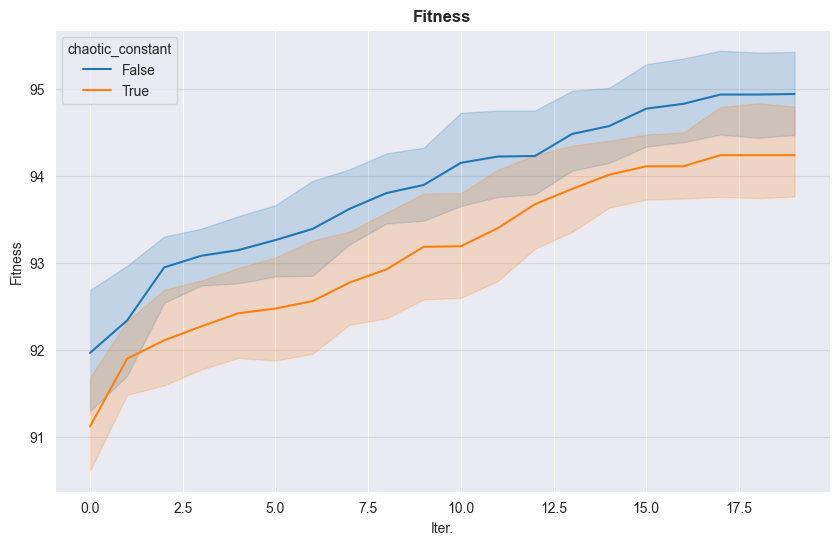

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=train_df,
             x="Iteration",
             y="Fitness",
             hue="chaotic_constant",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

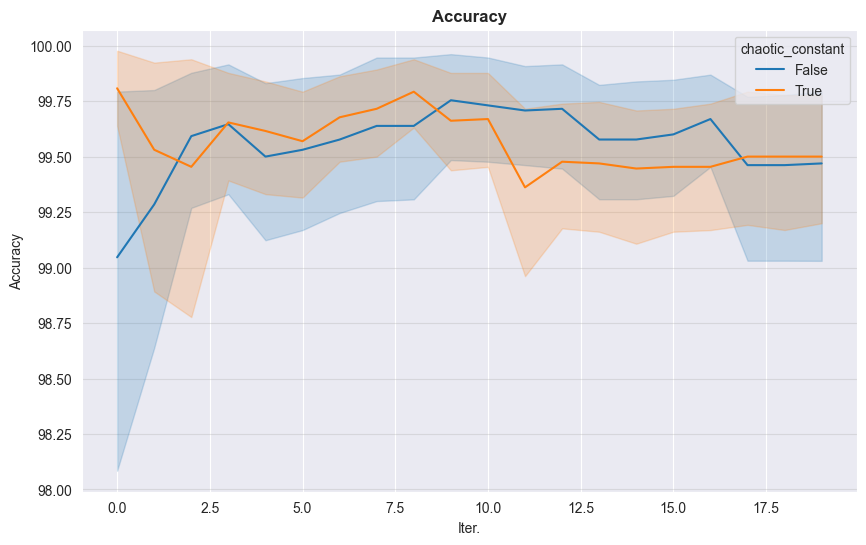

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Accuracy", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=train_df,
             x="Iteration",
             y="Accuracy",
             hue="chaotic_constant",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Accuracy")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [20]:
# T-test results (with and without Chaotic constant)

# accuracy history in train_df between chaotic_constant=True and chaotic_constant=False
chaotic_constant_true = train_df[train_df["chaotic_constant"] == True]["Accuracy"]
chaotic_constant_false = train_df[train_df["chaotic_constant"] == False]["Accuracy"]

st.ttest_ind(chaotic_constant_true, chaotic_constant_false)

TtestResult(statistic=0.11587281338755652, pvalue=0.9078117832441424, df=398.0)

# Compare accuracy weight (wa) and fitness weight (wf) effect on the number of features and convergence of accuracy and fitness

In [21]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()

for wa in np.arange(0.1, 1.0, 0.1):
    wf = 1 - wa
    print(f"Running GSA with wa = {wa}, wf = {wf}")
    tr_df, tt_df = run_gsa(uci_data,
                               runs=10,
                               population_size=5,
                               iterations=20)
    
    tr_df["wa"] = wa
    tt_df["wa"] = wf
    train_df = pd.concat([train_df, tr_df], axis=0)
    test_df = pd.concat([test_df, tt_df], axis=0)

Running GSA with wa = 0.1, wf = 0.9
GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 63.18181818181817']


/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 66.91118881118881']
['At iteration 3 the best fitness is 66.91118881118881']
['At iteration 4 the best fitness is 66.91118881118881']
['At iteration 5 the best fitness is 66.91118881118881']
['At iteration 6 the best fitness is 66.91118881118881']
['At iteration 7 the best fitness is 66.91118881118881']
['At iteration 8 the best fitness is 66.91118881118881']
['At iteration 9 the best fitness is 67.03408216110294']
['At iteration 10 the best fitness is 67.03408216110294']
['At iteration 11 the best fitness is 67.03408216110294']
['At iteration 12 the best fitness is 71.36363636363637']
['At iteration 13 the best fitness is 71.36363636363637']
['At iteration 14 the best fitness is 71.36363636363637']
['At iteration 15 the best fitness is 71.36363636363637']
['At iteration 16 the best fitness is 75.03916083916086']
['At iteration 17 the best fitness is 75.03916083916086']
['At iteration 18 the best fitness is 75.03916083916086']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 67.27272727272728']
['At iteration 2 the best fitness is 71.36363636363637']
['At iteration 3 the best fitness is 71.36363636363637']
['At iteration 4 the best fitness is 71.36363636363637']
['At iteration 5 the best fitness is 71.36363636363637']
['At iteration 6 the best fitness is 71.36363636363637']
['At iteration 7 the best fitness is 71.36363636363637']
['At iteration 8 the best fitness is 71.36363636363637']
['At iteration 9 the best fitness is 71.36363636363637']
['At iteration 10 the best fitness is 71.36363636363637']
['At iteration 11 the best fitness is 71.36363636363637']
['At iteration 12 the best fitness is 71.36363636363637']
['At iteration 13 the best fitness is 71.36363636363637']
['At iteration 14 the best fitness is 71.36363636363637']
['At iteration 15 the best fitness is 71.36363636363637']
['At iteration 16 the best fitness is 71.36363636363637']
['At iteration 17 the best fitness is 71.3636363

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 67.27272727272728']
['At iteration 3 the best fitness is 71.36363636363637']
['At iteration 4 the best fitness is 71.36363636363637']
['At iteration 5 the best fitness is 71.36363636363637']
['At iteration 6 the best fitness is 71.36363636363637']
['At iteration 7 the best fitness is 71.36363636363637']
['At iteration 8 the best fitness is 75.40069930069932']
['At iteration 9 the best fitness is 75.40069930069932']
['At iteration 10 the best fitness is 75.40069930069932']
['At iteration 11 the best fitness is 75.40069930069932']
['At iteration 12 the best fitness is 75.40069930069932']
['At iteration 13 the best fitness is 75.40069930069932']
['At iteration 14 the best fitness is 75.40069930069932']
['At iteration 15 the best fitness is 75.40069930069932']
['At iteration 16 the best fitness is 75.40069930069932']
['At iteration 17 the best fitness is 75.40069930069932']
['At iteration 18 the best fitness is 75.40069930069932']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 63.1664217230037']
['At iteration 2 the best fitness is 66.76503496503497']
['At iteration 3 the best fitness is 66.76503496503497']
['At iteration 4 the best fitness is 67.25734265734266']
['At iteration 5 the best fitness is 67.25734265734266']
['At iteration 6 the best fitness is 67.25734265734266']
['At iteration 7 the best fitness is 67.25734265734266']
['At iteration 8 the best fitness is 67.25734265734266']
['At iteration 9 the best fitness is 67.25734265734266']
['At iteration 10 the best fitness is 67.25734265734266']
['At iteration 11 the best fitness is 67.25734265734266']
['At iteration 12 the best fitness is 67.25734265734266']
['At iteration 13 the best fitness is 67.27272727272728']
['At iteration 14 the best fitness is 67.27272727272728']
['At iteration 15 the best fitness is 67.27272727272728']
['At iteration 16 the best fitness is 67.27272727272728']
['At iteration 17 the best fitness is 67.27272727272728']
['At iteration 18 the be

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 59.090909090909086']
['At iteration 2 the best fitness is 63.18181818181817']
['At iteration 3 the best fitness is 63.18181818181817']
['At iteration 4 the best fitness is 67.24965034965035']
['At iteration 5 the best fitness is 67.24965034965035']
['At iteration 6 the best fitness is 67.24965034965035']
['At iteration 7 the best fitness is 71.22506823430612']
['At iteration 8 the best fitness is 71.22506823430612']
['At iteration 9 the best fitness is 75.16971096647772']
['At iteration 10 the best fitness is 75.16971096647772']
['At iteration 11 the best fitness is 75.16971096647772']
['At iteration 12 the best fitness is 75.16971096647772']
['At iteration 13 the best fitness is 75.16971096647772']
['At iteration 14 the best fitness is 81.64405594405595']
['At iteration 15 the best fitness is 81.64405594405595']
['At iteration 16 the best fitness is 83.05944055944056']
['At iteration 17 the best fitness is 83.05944055944056']
['At iteration 18 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 67.24965034965035']
['At iteration 3 the best fitness is 67.24965034965035']
['At iteration 4 the best fitness is 67.24965034965035']
['At iteration 5 the best fitness is 67.24965034965035']
['At iteration 6 the best fitness is 67.27272727272728']
['At iteration 7 the best fitness is 67.27272727272728']
['At iteration 8 the best fitness is 67.27272727272728']
['At iteration 9 the best fitness is 67.27272727272728']
['At iteration 10 the best fitness is 67.27272727272728']
['At iteration 11 the best fitness is 67.27272727272728']
['At iteration 12 the best fitness is 67.27272727272728']
['At iteration 13 the best fitness is 67.27272727272728']
['At iteration 14 the best fitness is 67.27272727272728']
['At iteration 15 the best fitness is 67.27272727272728']
['At iteration 16 the best fitness is 67.27272727272728']
['At iteration 17 the best fitness is 67.27272727272728']
['At iteration 18 the best fitness is 67.27272727272728']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 55.0']
['At iteration 2 the best fitness is 67.22657342657342']
['At iteration 3 the best fitness is 67.22657342657342']
['At iteration 4 the best fitness is 67.22657342657342']
['At iteration 5 the best fitness is 67.22657342657342']
['At iteration 6 the best fitness is 67.22657342657342']
['At iteration 7 the best fitness is 67.22657342657342']
['At iteration 8 the best fitness is 67.22657342657342']
['At iteration 9 the best fitness is 67.22657342657342']
['At iteration 10 the best fitness is 67.24965034965035']
['At iteration 11 the best fitness is 67.24965034965035']
['At iteration 12 the best fitness is 67.24965034965035']
['At iteration 13 the best fitness is 67.24965034965035']
['At iteration 14 the best fitness is 67.24965034965035']
['At iteration 15 the best fitness is 67.24965034965035']
['At iteration 16 the best fitness is 67.25734265734266']
['At iteration 17 the best fitness is 67.25734265734266']
['At iteration 18 the best fitness i

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 63.0048951048951']
['At iteration 2 the best fitness is 63.0048951048951']
['At iteration 3 the best fitness is 63.0048951048951']
['At iteration 4 the best fitness is 77.95314685314685']
['At iteration 5 the best fitness is 77.95314685314685']
['At iteration 6 the best fitness is 78.63776223776225']
['At iteration 7 the best fitness is 78.63776223776225']
['At iteration 8 the best fitness is 78.63776223776225']
['At iteration 9 the best fitness is 78.63776223776225']
['At iteration 10 the best fitness is 78.63776223776225']
['At iteration 11 the best fitness is 78.63776223776225']
['At iteration 12 the best fitness is 78.63776223776225']
['At iteration 13 the best fitness is 78.63776223776225']
['At iteration 14 the best fitness is 78.63776223776225']
['At iteration 15 the best fitness is 78.63776223776225']
['At iteration 16 the best fitness is 78.63776223776225']
['At iteration 17 the best fitness is 78.63776223776225']
['At iteration 18 the best

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 63.18181818181817']
['At iteration 2 the best fitness is 71.36363636363637']
['At iteration 3 the best fitness is 71.36363636363637']
['At iteration 4 the best fitness is 71.36363636363637']
['At iteration 5 the best fitness is 83.4825174825175']
['At iteration 6 the best fitness is 83.4825174825175']
['At iteration 7 the best fitness is 83.4825174825175']
['At iteration 8 the best fitness is 83.4825174825175']
['At iteration 9 the best fitness is 83.4825174825175']
['At iteration 10 the best fitness is 83.4825174825175']
['At iteration 11 the best fitness is 83.4825174825175']
['At iteration 12 the best fitness is 83.4825174825175']
['At iteration 13 the best fitness is 83.4825174825175']
['At iteration 14 the best fitness is 83.4825174825175']
['At iteration 15 the best fitness is 83.4825174825175']
['At iteration 16 the best fitness is 83.4825174825175']
['At iteration 17 the best fitness is 83.4825174825175']
['At iteration 18 the best fitness i

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 75.41608391608393']
['At iteration 3 the best fitness is 75.41608391608393']
['At iteration 4 the best fitness is 79.48391608391609']
['At iteration 5 the best fitness is 79.48391608391609']
['At iteration 6 the best fitness is 79.48391608391609']
['At iteration 7 the best fitness is 79.48391608391609']
['At iteration 8 the best fitness is 79.48391608391609']
['At iteration 9 the best fitness is 79.48391608391609']
['At iteration 10 the best fitness is 79.48391608391609']
['At iteration 11 the best fitness is 79.48391608391609']
['At iteration 12 the best fitness is 79.48391608391609']
['At iteration 13 the best fitness is 79.48391608391609']
['At iteration 14 the best fitness is 79.48391608391609']
['At iteration 15 the best fitness is 79.54545454545455']
['At iteration 16 the best fitness is 79.54545454545455']
['At iteration 17 the best fitness is 79.54545454545455']
['At iteration 18 the best fitness is 83.60559440559442']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 63.63636363636363']
['At iteration 2 the best fitness is 74.54545454545456']
['At iteration 3 the best fitness is 74.54545454545456']
['At iteration 4 the best fitness is 74.54545454545456']
['At iteration 5 the best fitness is 74.54545454545456']
['At iteration 6 the best fitness is 74.54545454545456']
['At iteration 7 the best fitness is 74.54545454545456']
['At iteration 8 the best fitness is 74.54545454545456']
['At iteration 9 the best fitness is 74.54545454545456']
['At iteration 10 the best fitness is 81.72860242144307']
['At iteration 11 the best fitness is 81.72860242144307']
['At iteration 12 the best fitness is 81.72860242144307']
['At iteration 13 the best fitness is 84.3006993006993']
['At iteration 14 the best fitness is 84.3006993006993']
['At iteration 15 the best fitness is 84.3006993006993']
['At iteration 16 the best fitness is 84.3006993006993']
['At iteration 17 the best fitness is 84.3006993006993']
['At iteration 18 the best f

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 72.36083916083916']
['At iteration 2 the best fitness is 72.36083916083916']
['At iteration 3 the best fitness is 75.12027972027973']
['At iteration 4 the best fitness is 75.12027972027973']
['At iteration 5 the best fitness is 81.61818181818181']
['At iteration 6 the best fitness is 81.61818181818181']
['At iteration 7 the best fitness is 81.61818181818181']
['At iteration 8 the best fitness is 81.61818181818181']
['At iteration 9 the best fitness is 81.61818181818181']
['At iteration 10 the best fitness is 81.61818181818181']
['At iteration 11 the best fitness is 81.82377622377622']
['At iteration 12 the best fitness is 81.82377622377622']
['At iteration 13 the best fitness is 81.82377622377622']
['At iteration 14 the best fitness is 81.82377622377622']
['At iteration 15 the best fitness is 81.82377622377622']
['At iteration 16 the best fitness is 81.82377622377622']
['At iteration 17 the best fitness is 81.8237762

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 74.3916083916084']
['At iteration 3 the best fitness is 74.3916083916084']
['At iteration 4 the best fitness is 74.3916083916084']
['At iteration 5 the best fitness is 74.3916083916084']
['At iteration 6 the best fitness is 74.3916083916084']
['At iteration 7 the best fitness is 78.1048951048951']
['At iteration 8 the best fitness is 78.1048951048951']
['At iteration 9 the best fitness is 78.1048951048951']
['At iteration 10 the best fitness is 78.1048951048951']
['At iteration 11 the best fitness is 78.1048951048951']
['At iteration 12 the best fitness is 78.1048951048951']
['At iteration 13 the best fitness is 78.1048951048951']
['At iteration 14 the best fitness is 78.1048951048951']
['At iteration 15 the best fitness is 78.1048951048951']
['At iteration 16 the best fitness is 78.1048951048951']
['At iteration 17 the best fitness is 78.1048951048951']
['At iteration 18 the best fitness is 78.1048951048951']
['At iteration 19 the best fitness is 7

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 63.54405594405594']
['At iteration 2 the best fitness is 74.13006993006994']
['At iteration 3 the best fitness is 74.13006993006994']
['At iteration 4 the best fitness is 76.61258741258742']
['At iteration 5 the best fitness is 76.61258741258742']
['At iteration 6 the best fitness is 76.61258741258742']
['At iteration 7 the best fitness is 76.61258741258742']
['At iteration 8 the best fitness is 76.61258741258742']
['At iteration 9 the best fitness is 76.61258741258742']
['At iteration 10 the best fitness is 76.61258741258742']
['At iteration 11 the best fitness is 76.61258741258742']
['At iteration 12 the best fitness is 76.61258741258742']
['At iteration 13 the best fitness is 76.61258741258742']
['At iteration 14 the best fitness is 77.85874125874126']
['At iteration 15 the best fitness is 77.85874125874126']
['At iteration 16 the best fitness is 77.85874125874126']
['At iteration 17 the best fitness is 77.85874125874126']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 60.0']
['At iteration 2 the best fitness is 63.63636363636363']
['At iteration 3 the best fitness is 63.63636363636363']
['At iteration 4 the best fitness is 63.63636363636363']
['At iteration 5 the best fitness is 63.63636363636363']
['At iteration 6 the best fitness is 67.22653789628384']
['At iteration 7 the best fitness is 67.22653789628384']
['At iteration 8 the best fitness is 67.22653789628384']
['At iteration 9 the best fitness is 67.27272727272727']
['At iteration 10 the best fitness is 67.27272727272727']
['At iteration 11 the best fitness is 67.27272727272727']
['At iteration 12 the best fitness is 70.9090909090909']
['At iteration 13 the best fitness is 77.55104895104895']
['At iteration 14 the best fitness is 77.55104895104895']
['At iteration 15 the best fitness is 77.55104895104895']
['At iteration 16 the best fitness is 77.55104895104895']
['At iteration 17 the best fitness is 77.55104895104895']
['At iteration 18 the best fitness is

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 70.9090909090909']
['At iteration 2 the best fitness is 70.9090909090909']
['At iteration 3 the best fitness is 70.9090909090909']
['At iteration 4 the best fitness is 70.9090909090909']
['At iteration 5 the best fitness is 70.9090909090909']
['At iteration 6 the best fitness is 74.20699300699302']
['At iteration 7 the best fitness is 80.97202797202797']
['At iteration 8 the best fitness is 80.97202797202797']
['At iteration 9 the best fitness is 80.97202797202797']
['At iteration 10 the best fitness is 80.97202797202797']
['At iteration 11 the best fitness is 87.44475524475524']
['At iteration 12 the best fitness is 87.44475524475524']
['At iteration 13 the best fitness is 87.44475524475524']
['At iteration 14 the best fitness is 87.44475524475524']
['At iteration 15 the best fitness is 87.44475524475524']
['At iteration 16 the best fitness is 87.44475524475524']
['At iteration 17 the best fitness is 87.444755244755

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 70.87829799146196']
['At iteration 2 the best fitness is 74.51468531468532']
['At iteration 3 the best fitness is 74.51468531468532']
['At iteration 4 the best fitness is 74.51468531468532']
['At iteration 5 the best fitness is 74.51468531468532']
['At iteration 6 the best fitness is 74.51468531468532']
['At iteration 7 the best fitness is 74.51468531468532']
['At iteration 8 the best fitness is 77.42797202797203']
['At iteration 9 the best fitness is 77.42797202797203']
['At iteration 10 the best fitness is 77.42797202797203']
['At iteration 11 the best fitness is 77.42797202797203']
['At iteration 12 the best fitness is 77.42797202797203']
['At iteration 13 the best fitness is 77.42797202797203']
['At iteration 14 the best fitness is 77.42797202797203']
['At iteration 15 the best fitness is 77.70489510489512']
['At iteration 16 the best fitness is 77.70489510489512']
['At iteration 17 the best fitness is 77.70489510489512']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 74.20673245153615']
['At iteration 2 the best fitness is 74.20673245153615']
['At iteration 3 the best fitness is 77.67373504094058']
['At iteration 4 the best fitness is 77.67373504094058']
['At iteration 5 the best fitness is 77.67373504094058']
['At iteration 6 the best fitness is 77.67373504094058']
['At iteration 7 the best fitness is 77.67373504094058']
['At iteration 8 the best fitness is 77.8895104895105']
['At iteration 9 the best fitness is 77.8895104895105']
['At iteration 10 the best fitness is 77.8895104895105']
['At iteration 11 the best fitness is 77.8895104895105']
['At iteration 12 the best fitness is 77.8895104895105']
['At iteration 13 the best fitness is 77.8895104895105']
['At iteration 14 the best fitness is 77.8895104895105']
['At iteration 15 the best fitness is 77.8895104895105']
['At iteration 16 the best fitness is 77.8895104895105']
['At iteration 17 the best fitness is 77.8895104895105']
['At iteration 18 the best fitnes

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 67.27272727272727']
['At iteration 2 the best fitness is 67.27272727272727']
['At iteration 3 the best fitness is 67.27272727272727']
['At iteration 4 the best fitness is 67.27272727272727']
['At iteration 5 the best fitness is 67.27272727272727']
['At iteration 6 the best fitness is 67.27272727272727']
['At iteration 7 the best fitness is 67.27272727272727']
['At iteration 8 the best fitness is 67.27272727272727']
['At iteration 9 the best fitness is 67.27272727272727']
['At iteration 10 the best fitness is 67.27272727272727']
['At iteration 11 the best fitness is 67.27272727272727']
['At iteration 12 the best fitness is 67.27272727272727']
['At iteration 13 the best fitness is 67.27272727272727']
['At iteration 14 the best fitness is 70.9090909090909']
['At iteration 15 the best fitness is 70.9090909090909']
['At iteration 16 the best fitness is 70.9090909090909']
['At iteration 17 the best fitness is 70.9090909090909']
['At iteration 18 the best 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 74.22212891035062']
['At iteration 3 the best fitness is 74.22212891035062']
['At iteration 4 the best fitness is 74.22212891035062']
['At iteration 5 the best fitness is 81.67972027972027']
['At iteration 6 the best fitness is 81.67972027972027']
['At iteration 7 the best fitness is 84.1006993006993']
['At iteration 8 the best fitness is 84.1006993006993']
['At iteration 9 the best fitness is 84.1006993006993']
['At iteration 10 the best fitness is 84.1006993006993']
['At iteration 11 the best fitness is 84.1006993006993']
['At iteration 12 the best fitness is 84.1006993006993']
['At iteration 13 the best fitness is 84.1006993006993']
['At iteration 14 the best fitness is 84.1006993006993']
['At iteration 15 the best fitness is 84.1006993006993']
['At iteration 16 the best fitness is 84.1006993006993']
['At iteration 17 the best fitness is 84.1006993006993']
['At iteration 18 the best fitness is 84.1006993006993']
['At iteration 19 the best fitness

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 74.54545454545455']
['At iteration 3 the best fitness is 74.54545454545455']
['At iteration 4 the best fitness is 74.54545454545455']
['At iteration 5 the best fitness is 83.9986013986014']
['At iteration 6 the best fitness is 83.9986013986014']
['At iteration 7 the best fitness is 86.32657342657342']
['At iteration 8 the best fitness is 86.32657342657342']
['At iteration 9 the best fitness is 90.33916083916083']
['At iteration 10 the best fitness is 90.33916083916083']
['At iteration 11 the best fitness is 90.33916083916083']
['At iteration 12 the best fitness is 90.33916083916083']
['At iteration 13 the best fitness is 90.33916083916083']
['At iteration 14 the best fitness is 90.33916083916083']
['At iteration 15 the best fitness is 90.33916083916083']
['At iteration 16 the best fitness is 90.33916083916083']
['At iteration 17 the best fitness is 90.33916083916083']
['At iteration 18 the best fitness is 90.33916083916083']
['At iteration 19 the be

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 68.13566433566433']
['At iteration 2 the best fitness is 78.99223178668908']
['At iteration 3 the best fitness is 78.99223178668908']
['At iteration 4 the best fitness is 78.99223178668908']
['At iteration 5 the best fitness is 78.99223178668908']
['At iteration 6 the best fitness is 78.99223178668908']
['At iteration 7 the best fitness is 80.53986013986014']
['At iteration 8 the best fitness is 80.53986013986014']
['At iteration 9 the best fitness is 83.56013986013986']
['At iteration 10 the best fitness is 83.56013986013986']
['At iteration 11 the best fitness is 83.56013986013986']
['At iteration 12 the best fitness is 83.56013986013986']
['At iteration 13 the best fitness is 83.56013986013986']
['At iteration 14 the best fitness is 83.56013986013986']
['At iteration 15 the best fitness is 83.56013986013986']
['At iteration 16 the best fitness is 83.56013986013986']
['At iteration 17 the best fitness is 83.56013986013986']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 71.36363636363636']
['At iteration 2 the best fitness is 74.54545454545455']
['At iteration 3 the best fitness is 74.54545454545455']
['At iteration 4 the best fitness is 74.54545454545455']
['At iteration 5 the best fitness is 77.68111888111889']
['At iteration 6 the best fitness is 77.68111888111889']
['At iteration 7 the best fitness is 77.68111888111889']
['At iteration 8 the best fitness is 77.68111888111889']
['At iteration 9 the best fitness is 77.68111888111889']
['At iteration 10 the best fitness is 77.68111888111889']
['At iteration 11 the best fitness is 77.68111888111889']
['At iteration 12 the best fitness is 77.68111888111889']
['At iteration 13 the best fitness is 77.68111888111889']
['At iteration 14 the best fitness is 77.68111888111889']
['At iteration 15 the best fitness is 77.68111888111889']
['At iteration 16 the best fitness is 77.68111888111889']
['At iteration 17 the best fitness is 77.68111888111889']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 76.01958041958042']
['At iteration 3 the best fitness is 78.71678321678323']
['At iteration 4 the best fitness is 78.71678321678323']
['At iteration 5 the best fitness is 82.63706293706294']
['At iteration 6 the best fitness is 82.63706293706294']
['At iteration 7 the best fitness is 82.63706293706294']
['At iteration 8 the best fitness is 82.63706293706294']
['At iteration 9 the best fitness is 82.63706293706294']
['At iteration 10 the best fitness is 82.63706293706294']
['At iteration 11 the best fitness is 82.63706293706294']
['At iteration 12 the best fitness is 82.63706293706294']
['At iteration 13 the best fitness is 82.63706293706294']
['At iteration 14 the best fitness is 82.63706293706294']
['At iteration 15 the best fitness is 82.63706293706294']
['At iteration 16 the best fitness is 83.76783216783217']
['At iteration 17 the best fitness is 83.76783216783217']
['At iteration 18 the best fitness is 83.76783216783217']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 67.67373504094058']
['At iteration 2 the best fitness is 74.54545454545455']
['At iteration 3 the best fitness is 74.54545454545455']
['At iteration 4 the best fitness is 74.54545454545455']
['At iteration 5 the best fitness is 77.4965034965035']
['At iteration 6 the best fitness is 77.4965034965035']
['At iteration 7 the best fitness is 77.4965034965035']
['At iteration 8 the best fitness is 77.4965034965035']
['At iteration 9 the best fitness is 77.4965034965035']
['At iteration 10 the best fitness is 77.4965034965035']
['At iteration 11 the best fitness is 77.4965034965035']
['At iteration 12 the best fitness is 77.4965034965035']
['At iteration 13 the best fitness is 77.72727272727273']
['At iteration 14 the best fitness is 77.72727272727273']
['At iteration 15 the best fitness is 80.0986013986014']
['At iteration 16 the best fitness is 80.0986013986014']
['At iteration 17 the best fitness is 82.75244755244755']
['At iteration 18 the best fitnes

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 71.36363636363636']
['At iteration 2 the best fitness is 77.4039470921688']
['At iteration 3 the best fitness is 77.4039470921688']
['At iteration 4 the best fitness is 77.4039470921688']
['At iteration 5 the best fitness is 77.4039470921688']
['At iteration 6 the best fitness is 77.42727272727274']
['At iteration 7 the best fitness is 77.42727272727274']
['At iteration 8 the best fitness is 77.42727272727274']
['At iteration 9 the best fitness is 77.42727272727274']
['At iteration 10 the best fitness is 77.42727272727274']
['At iteration 11 the best fitness is 77.42727272727274']
['At iteration 12 the best fitness is 77.42727272727274']
['At iteration 13 the best fitness is 77.42727272727274']
['At iteration 14 the best fitness is 77.42727272727274']
['At iteration 15 the best fitness is 77.42727272727274']
['At iteration 16 the best fitness is 77.42727272727274']
['At iteration 17 the best fitness is 80.37791307999161']
['At iteration 18 the best 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 76.22727272727273']
['At iteration 3 the best fitness is 77.54265734265735']
['At iteration 4 the best fitness is 77.54265734265735']
['At iteration 5 the best fitness is 77.54265734265735']
['At iteration 6 the best fitness is 77.54265734265735']
['At iteration 7 the best fitness is 77.54265734265735']
['At iteration 8 the best fitness is 79.73216783216785']
['At iteration 9 the best fitness is 79.73216783216785']
['At iteration 10 the best fitness is 79.73216783216785']
['At iteration 11 the best fitness is 79.73216783216785']
['At iteration 12 the best fitness is 79.73216783216785']
['At iteration 13 the best fitness is 79.73216783216785']
['At iteration 14 the best fitness is 79.73216783216785']
['At iteration 15 the best fitness is 79.73216783216785']
['At iteration 16 the best fitness is 79.73216783216785']
['At iteration 17 the best fitness is 81.57358807474282']
['At iteration 18 the best fitness is 83.3986013986014']
['At iteration 19 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 74.52237762237762']
['At iteration 2 the best fitness is 77.51958041958042']
['At iteration 3 the best fitness is 77.51958041958042']
['At iteration 4 the best fitness is 77.51958041958042']
['At iteration 5 the best fitness is 77.51958041958042']
['At iteration 6 the best fitness is 77.58881118881119']
['At iteration 7 the best fitness is 77.58881118881119']
['At iteration 8 the best fitness is 77.58881118881119']
['At iteration 9 the best fitness is 77.58881118881119']
['At iteration 10 the best fitness is 77.68111888111889']
['At iteration 11 the best fitness is 80.03216783216783']
['At iteration 12 the best fitness is 80.03216783216783']
['At iteration 13 the best fitness is 80.03216783216783']
['At iteration 14 the best fitness is 80.03216783216783']
['At iteration 15 the best fitness is 80.03216783216783']
['At iteration 16 the best fitness is 80.03216783216783']
['At iteration 17 the best fitness is 80.03216783216783']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 76.61958041958042']
['At iteration 2 the best fitness is 77.63496503496503']
['At iteration 3 the best fitness is 83.90629370629371']
['At iteration 4 the best fitness is 83.90629370629371']
['At iteration 5 the best fitness is 83.90629370629371']
['At iteration 6 the best fitness is 83.90629370629371']
['At iteration 7 the best fitness is 83.90629370629371']
['At iteration 8 the best fitness is 83.90629370629371']
['At iteration 9 the best fitness is 83.90629370629371']
['At iteration 10 the best fitness is 83.90629370629371']
['At iteration 11 the best fitness is 83.90629370629371']
['At iteration 12 the best fitness is 83.90629370629371']
['At iteration 13 the best fitness is 83.90629370629371']
['At iteration 14 the best fitness is 83.90629370629371']
['At iteration 15 the best fitness is 83.90629370629371']
['At iteration 16 the best fitness is 83.90629370629371']
['At iteration 17 the best fitness is 83.90629370629371']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 71.36363636363636']
['At iteration 2 the best fitness is 77.47342657342658']
['At iteration 3 the best fitness is 77.47342657342658']
['At iteration 4 the best fitness is 79.52447552447553']
['At iteration 5 the best fitness is 79.52447552447553']
['At iteration 6 the best fitness is 79.52447552447553']
['At iteration 7 the best fitness is 79.52447552447553']
['At iteration 8 the best fitness is 79.52447552447553']
['At iteration 9 the best fitness is 79.52447552447553']
['At iteration 10 the best fitness is 79.52447552447553']
['At iteration 11 the best fitness is 79.52447552447553']
['At iteration 12 the best fitness is 79.52447552447553']
['At iteration 13 the best fitness is 79.52447552447553']
['At iteration 14 the best fitness is 79.52447552447553']
['At iteration 15 the best fitness is 79.52447552447553']
['At iteration 16 the best fitness is 79.52447552447553']
['At iteration 17 the best fitness is 79.52447552447553']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 77.93566433566434']
['At iteration 2 the best fitness is 78.08951048951049']
['At iteration 3 the best fitness is 78.08951048951049']
['At iteration 4 the best fitness is 78.08951048951049']
['At iteration 5 the best fitness is 78.18181818181819']
['At iteration 6 the best fitness is 78.18181818181819']
['At iteration 7 the best fitness is 78.18181818181819']
['At iteration 8 the best fitness is 80.4055944055944']
['At iteration 9 the best fitness is 80.4055944055944']
['At iteration 10 the best fitness is 82.12867132867133']
['At iteration 11 the best fitness is 82.12867132867133']
['At iteration 12 the best fitness is 82.3104895104895']
['At iteration 13 the best fitness is 82.3104895104895']
['At iteration 14 the best fitness is 82.3104895104895']
['At iteration 15 the best fitness is 82.3104895104895']
['At iteration 16 the best fitness is 82.3104895104895']
['At iteration 17 the best fitness is 82.3104895104895']
['At iteration 18 the best fitn

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 75.2083916083916']
['At iteration 2 the best fitness is 78.08951048951049']
['At iteration 3 the best fitness is 78.08951048951049']
['At iteration 4 the best fitness is 78.08951048951049']
['At iteration 5 the best fitness is 78.08951048951049']
['At iteration 6 the best fitness is 78.08951048951049']
['At iteration 7 the best fitness is 79.15524475524475']
['At iteration 8 the best fitness is 79.15524475524475']
['At iteration 9 the best fitness is 79.986013986014']
['At iteration 10 the best fitness is 79.986013986014']
['At iteration 11 the best fitness is 79.986013986014']
['At iteration 12 the best fitness is 79.986013986014']
['At iteration 13 the best fitness is 79.986013986014']
['At iteration 14 the best fitness is 83.51328671328672']
['At iteration 15 the best fitness is 83.51328671328672']
['At iteration 16 the best fitness is 83.51328671328672']
['At iteration 17 the best fitness is 83.83861711806284']
['At iteration 18 the best fitness

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 77.9972027972028']
['At iteration 3 the best fitness is 77.9972027972028']
['At iteration 4 the best fitness is 77.9972027972028']
['At iteration 5 the best fitness is 77.9972027972028']
['At iteration 6 the best fitness is 79.67832167832168']
['At iteration 7 the best fitness is 80.84755244755246']
['At iteration 8 the best fitness is 80.84755244755246']
['At iteration 9 the best fitness is 80.84755244755246']
['At iteration 10 the best fitness is 85.59440559440559']
['At iteration 11 the best fitness is 85.59440559440559']
['At iteration 12 the best fitness is 85.59440559440559']
['At iteration 13 the best fitness is 85.59440559440559']
['At iteration 14 the best fitness is 85.59440559440559']
['At iteration 15 the best fitness is 85.59440559440559']
['At iteration 16 the best fitness is 85.59440559440559']
['At iteration 17 the best fitness is 85.59440559440559']
['At iteration 18 the best fitness is 85.59440559440559']
['At iteration 19 the best

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 77.99706067604451']
['At iteration 2 the best fitness is 77.99706067604451']
['At iteration 3 the best fitness is 77.99706067604451']
['At iteration 4 the best fitness is 77.99706067604451']
['At iteration 5 the best fitness is 77.99706067604451']
['At iteration 6 the best fitness is 77.99706067604451']
['At iteration 7 the best fitness is 77.99706067604451']
['At iteration 8 the best fitness is 78.18181818181819']
['At iteration 9 the best fitness is 78.18181818181819']
['At iteration 10 the best fitness is 78.18181818181819']
['At iteration 11 the best fitness is 78.18181818181819']
['At iteration 12 the best fitness is 78.18181818181819']
['At iteration 13 the best fitness is 78.18181818181819']
['At iteration 14 the best fitness is 78.18181818181819']
['At iteration 15 the best fitness is 78.18181818181819']
['At iteration 16 the best fitness is 82.40559440559441']
['At iteration 17 the best fitness is 82.40559440559441']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 78.02797202797203']
['At iteration 2 the best fitness is 78.18181818181819']
['At iteration 3 the best fitness is 78.18181818181819']
['At iteration 4 the best fitness is 78.18181818181819']
['At iteration 5 the best fitness is 82.46713286713288']
['At iteration 6 the best fitness is 82.46713286713288']
['At iteration 7 the best fitness is 82.46713286713288']
['At iteration 8 the best fitness is 82.46713286713288']
['At iteration 9 the best fitness is 82.46713286713288']
['At iteration 10 the best fitness is 82.46713286713288']
['At iteration 11 the best fitness is 82.9902097902098']
['At iteration 12 the best fitness is 82.9902097902098']
['At iteration 13 the best fitness is 82.9902097902098']
['At iteration 14 the best fitness is 83.35944055944057']
['At iteration 15 the best fitness is 83.35944055944057']
['At iteration 16 the best fitness is 83.35944055944057']
['At iteration 17 the best fitness is 83.35944055944057']
['At iteration 18 the best

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 80.13986013986013']
['At iteration 3 the best fitness is 80.13986013986013']
['At iteration 4 the best fitness is 80.13986013986013']
['At iteration 5 the best fitness is 80.13986013986013']
['At iteration 6 the best fitness is 80.13986013986013']
['At iteration 7 the best fitness is 80.13986013986013']
['At iteration 8 the best fitness is 80.13986013986013']
['At iteration 9 the best fitness is 80.13986013986013']
['At iteration 10 the best fitness is 80.57036881517251']
['At iteration 11 the best fitness is 80.57036881517251']
['At iteration 12 the best fitness is 80.57036881517251']
['At iteration 13 the best fitness is 80.57036881517251']
['At iteration 14 the best fitness is 80.57036881517251']
['At iteration 15 the best fitness is 80.57036881517251']
['At iteration 16 the best fitness is 80.57036881517251']
['At iteration 17 the best fitness is 80.57036881517251']
['At iteration 18 the best fitness is 80.57036881517251']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 80.84755244755246']
['At iteration 3 the best fitness is 80.84755244755246']
['At iteration 4 the best fitness is 80.87832167832168']
['At iteration 5 the best fitness is 80.9090909090909']
['At iteration 6 the best fitness is 83.45174825174826']
['At iteration 7 the best fitness is 83.45174825174826']
['At iteration 8 the best fitness is 83.63636363636364']
['At iteration 9 the best fitness is 83.63636363636364']
['At iteration 10 the best fitness is 83.63636363636364']
['At iteration 11 the best fitness is 83.63636363636364']
['At iteration 12 the best fitness is 83.63636363636364']
['At iteration 13 the best fitness is 86.05570718734691']
['At iteration 14 the best fitness is 86.05570718734691']
['At iteration 15 the best fitness is 88.7521869969907']
['At iteration 16 the best fitness is 88.7521869969907']
['At iteration 17 the best fitness is 88.7521869969907']
['At iteration 18 the best fitness is 88.7521869969907']
['At iteration 19 the best 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 80.78601398601398']
['At iteration 2 the best fitness is 80.9090909090909']
['At iteration 3 the best fitness is 80.9090909090909']
['At iteration 4 the best fitness is 80.9090909090909']
['At iteration 5 the best fitness is 80.9090909090909']
['At iteration 6 the best fitness is 80.9090909090909']
['At iteration 7 the best fitness is 80.9090909090909']
['At iteration 8 the best fitness is 80.9090909090909']
['At iteration 9 the best fitness is 80.9090909090909']
['At iteration 10 the best fitness is 80.9090909090909']
['At iteration 11 the best fitness is 80.9090909090909']
['At iteration 12 the best fitness is 83.23636363636365']
['At iteration 13 the best fitness is 83.23636363636365']
['At iteration 14 the best fitness is 83.23636363636365']
['At iteration 15 the best fitness is 83.23636363636365']
['At iteration 16 the best fitness is 83.23636363636365']
['At iteration 17 the best fitness is 83.23636363636365']
['At iteration 18 the best fitnes

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 75.45454545454544']
['At iteration 2 the best fitness is 75.45454545454544']
['At iteration 3 the best fitness is 75.45454545454544']
['At iteration 4 the best fitness is 77.90468192315768']
['At iteration 5 the best fitness is 77.90468192315768']
['At iteration 6 the best fitness is 77.90468192315768']
['At iteration 7 the best fitness is 77.9972027972028']
['At iteration 8 the best fitness is 77.9972027972028']
['At iteration 9 the best fitness is 78.15104895104895']
['At iteration 10 the best fitness is 78.15104895104895']
['At iteration 11 the best fitness is 78.15104895104895']
['At iteration 12 the best fitness is 78.15104895104895']
['At iteration 13 the best fitness is 78.15104895104895']
['At iteration 14 the best fitness is 78.15104895104895']
['At iteration 15 the best fitness is 78.15104895104895']
['At iteration 16 the best fitness is 78.15104895104895']
['At iteration 17 the best fitness is 78.15104895104895']
['At iteration 18 the bes

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 75.45454545454544']
['At iteration 2 the best fitness is 77.65874125874126']
['At iteration 3 the best fitness is 77.65874125874126']
['At iteration 4 the best fitness is 78.57062937062938']
['At iteration 5 the best fitness is 80.50878297991463']
['At iteration 6 the best fitness is 80.50878297991463']
['At iteration 7 the best fitness is 80.50878297991463']
['At iteration 8 the best fitness is 80.50878297991463']
['At iteration 9 the best fitness is 80.50878297991463']
['At iteration 10 the best fitness is 80.50878297991463']
['At iteration 11 the best fitness is 82.43636363636364']
['At iteration 12 the best fitness is 82.43636363636364']
['At iteration 13 the best fitness is 83.93286713286713']
['At iteration 14 the best fitness is 83.93286713286713']
['At iteration 15 the best fitness is 83.93286713286713']
['At iteration 16 the best fitness is 83.93286713286713']
['At iteration 17 the best fitness is 83.93286713286713']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 84.90097277626145']
['At iteration 3 the best fitness is 84.90097277626145']
['At iteration 4 the best fitness is 84.90097277626145']
['At iteration 5 the best fitness is 88.52089019525509']
['At iteration 6 the best fitness is 88.52089019525509']
['At iteration 7 the best fitness is 88.52089019525509']
['At iteration 8 the best fitness is 88.52089019525509']
['At iteration 9 the best fitness is 88.52089019525509']
['At iteration 10 the best fitness is 88.52089019525509']
['At iteration 11 the best fitness is 88.52089019525509']
['At iteration 12 the best fitness is 88.52089019525509']
['At iteration 13 the best fitness is 88.52089019525509']
['At iteration 14 the best fitness is 88.52089019525509']
['At iteration 15 the best fitness is 88.52089019525509']
['At iteration 16 the best fitness is 88.52089019525509']
['At iteration 17 the best fitness is 88.52089019525509']
['At iteration 18 the best fitness is 88.52089019525509']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 77.27272727272727']
['At iteration 2 the best fitness is 81.66433566433567']
['At iteration 3 the best fitness is 81.66433566433567']
['At iteration 4 the best fitness is 81.66433566433567']
['At iteration 5 the best fitness is 81.66433566433567']
['At iteration 6 the best fitness is 81.66433566433567']
['At iteration 7 the best fitness is 81.66433566433567']
['At iteration 8 the best fitness is 81.66433566433567']
['At iteration 9 the best fitness is 81.66433566433567']
['At iteration 10 the best fitness is 81.66433566433567']
['At iteration 11 the best fitness is 81.66433566433567']
['At iteration 12 the best fitness is 83.3986013986014']
['At iteration 13 the best fitness is 83.47552447552448']
['At iteration 14 the best fitness is 83.47552447552448']
['At iteration 15 the best fitness is 83.47552447552448']
['At iteration 16 the best fitness is 83.47552447552448']
['At iteration 17 the best fitness is 83.47552447

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 81.81818181818181']
['At iteration 3 the best fitness is 84.0909090909091']
['At iteration 4 the best fitness is 84.0909090909091']
['At iteration 5 the best fitness is 84.0909090909091']
['At iteration 6 the best fitness is 84.0909090909091']
['At iteration 7 the best fitness is 84.0909090909091']
['At iteration 8 the best fitness is 84.0909090909091']
['At iteration 9 the best fitness is 86.6013986013986']
['At iteration 10 the best fitness is 86.6013986013986']
['At iteration 11 the best fitness is 86.6013986013986']
['At iteration 12 the best fitness is 86.6013986013986']
['At iteration 13 the best fitness is 86.6013986013986']
['At iteration 14 the best fitness is 86.6013986013986']
['At iteration 15 the best fitness is 86.6013986013986']
['At iteration 16 the best fitness is 86.6013986013986']
['At iteration 17 the best fitness is 86.6013986013986']
['At iteration 18 the best fitness is 88.32867132867133']
['At iteration 19 the best fitness is

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 79.27601651620127']
['At iteration 3 the best fitness is 79.77972027972028']
['At iteration 4 the best fitness is 79.77972027972028']
['At iteration 5 the best fitness is 79.77972027972028']
['At iteration 6 the best fitness is 79.77972027972028']
['At iteration 7 the best fitness is 79.77972027972028']
['At iteration 8 the best fitness is 79.77972027972028']
['At iteration 9 the best fitness is 81.81818181818181']
['At iteration 10 the best fitness is 81.81818181818181']
['At iteration 11 the best fitness is 81.81818181818181']
['At iteration 12 the best fitness is 81.81818181818181']
['At iteration 13 the best fitness is 81.81818181818181']
['At iteration 14 the best fitness is 81.81818181818181']
['At iteration 15 the best fitness is 81.81818181818181']
['At iteration 16 the best fitness is 81.81818181818181']
['At iteration 17 the best fitness is 81.81818181818181']
['At iteration 18 the best fitness is 81.81818181818181']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 79.54545454545453']
['At iteration 2 the best fitness is 81.77969067114563']
['At iteration 3 the best fitness is 81.81818181818181']
['At iteration 4 the best fitness is 81.81818181818181']
['At iteration 5 the best fitness is 86.13286713286715']
['At iteration 6 the best fitness is 86.13286713286715']
['At iteration 7 the best fitness is 86.13286713286715']
['At iteration 8 the best fitness is 86.13286713286715']
['At iteration 9 the best fitness is 86.13286713286715']
['At iteration 10 the best fitness is 86.24825174825175']
['At iteration 11 the best fitness is 86.24825174825175']
['At iteration 12 the best fitness is 86.24825174825175']
['At iteration 13 the best fitness is 86.24825174825175']
['At iteration 14 the best fitness is 86.24825174825175']
['At iteration 15 the best fitness is 90.4090909090909']
['At iteration 16 the best fitness is 90.52447552447552']
['At iteration 17 the best fitness is 90.52447552447552']
['At iteration 18 the be

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 78.54545454545453']
['At iteration 2 the best fitness is 82.16635173910001']
['At iteration 3 the best fitness is 82.16635173910001']
['At iteration 4 the best fitness is 82.16635173910001']
['At iteration 5 the best fitness is 86.0944055944056']
['At iteration 6 the best fitness is 86.0944055944056']
['At iteration 7 the best fitness is 88.4055944055944']
['At iteration 8 the best fitness is 88.4055944055944']
['At iteration 9 the best fitness is 88.4055944055944']
['At iteration 10 the best fitness is 88.4055944055944']
['At iteration 11 the best fitness is 88.4055944055944']
['At iteration 12 the best fitness is 88.4055944055944']
['At iteration 13 the best fitness is 88.4055944055944']
['At iteration 14 the best fitness is 88.4055944055944']
['At iteration 15 the best fitness is 88.4055944055944']
['At iteration 16 the best fitness is 88.4055944055944']
['At iteration 17 the best fitness is 88.4055944055944']
['At iteration 18 the best fitness i

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 79.54545454545453']
['At iteration 2 the best fitness is 81.81818181818181']
['At iteration 3 the best fitness is 81.81818181818181']
['At iteration 4 the best fitness is 81.81818181818181']
['At iteration 5 the best fitness is 81.81818181818181']
['At iteration 6 the best fitness is 81.81818181818181']
['At iteration 7 the best fitness is 81.81818181818181']
['At iteration 8 the best fitness is 81.81818181818181']
['At iteration 9 the best fitness is 84.01392679683673']
['At iteration 10 the best fitness is 84.01392679683673']
['At iteration 11 the best fitness is 84.0909090909091']
['At iteration 12 the best fitness is 84.0909090909091']
['At iteration 13 the best fitness is 86.36363636363637']
['At iteration 14 the best fitness is 86.36363636363637']
['At iteration 15 the best fitness is 86.36363636363637']
['At iteration 16 the best fitness is 86.36363636363637']
['At iteration 17 the best fitness is 86.363636363

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 75.0']
['At iteration 2 the best fitness is 83.94055944055944']
['At iteration 3 the best fitness is 83.94055944055944']
['At iteration 4 the best fitness is 85.78801875568618']
['At iteration 5 the best fitness is 85.78801875568618']
['At iteration 6 the best fitness is 85.78801875568618']
['At iteration 7 the best fitness is 85.78801875568618']
['At iteration 8 the best fitness is 85.78801875568618']
['At iteration 9 the best fitness is 85.78801875568618']
['At iteration 10 the best fitness is 85.78801875568618']
['At iteration 11 the best fitness is 85.78801875568618']
['At iteration 12 the best fitness is 85.78801875568618']
['At iteration 13 the best fitness is 85.78801875568618']
['At iteration 14 the best fitness is 85.78801875568618']
['At iteration 15 the best fitness is 86.20979020979021']
['At iteration 16 the best fitness is 86.20979020979021']
['At iteration 17 the best fitness is 86.36363636363637']
['At iteration 18 the best fitness i

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 84.0909090909091']
['At iteration 3 the best fitness is 84.0909090909091']
['At iteration 4 the best fitness is 84.0909090909091']
['At iteration 5 the best fitness is 84.0909090909091']
['At iteration 6 the best fitness is 86.98124431380782']
['At iteration 7 the best fitness is 86.98124431380782']
['At iteration 8 the best fitness is 86.98124431380782']
['At iteration 9 the best fitness is 86.98124431380782']
['At iteration 10 the best fitness is 86.98124431380782']
['At iteration 11 the best fitness is 86.98124431380782']
['At iteration 12 the best fitness is 86.98124431380782']
['At iteration 13 the best fitness is 86.98124431380782']
['At iteration 14 the best fitness is 86.98124431380782']
['At iteration 15 the best fitness is 86.98124431380782']
['At iteration 16 the best fitness is 86.98124431380782']
['At iteration 17 the best fitness is 86.98124431380782']
['At iteration 18 the best fitness is 86.98124431380782']
['At iteration 19 the best

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 83.7062937062937']
['At iteration 2 the best fitness is 83.7062937062937']
['At iteration 3 the best fitness is 85.6013986013986']
['At iteration 4 the best fitness is 85.6013986013986']
['At iteration 5 the best fitness is 85.6013986013986']
['At iteration 6 the best fitness is 85.6013986013986']
['At iteration 7 the best fitness is 85.6013986013986']
['At iteration 8 the best fitness is 85.6013986013986']
['At iteration 9 the best fitness is 85.6013986013986']
['At iteration 10 the best fitness is 85.6013986013986']
['At iteration 11 the best fitness is 85.6013986013986']
['At iteration 12 the best fitness is 85.6013986013986']
['At iteration 13 the best fitness is 85.6013986013986']
['At iteration 14 the best fitness is 85.6013986013986']
['At iteration 15 the best fitness is 85.6013986013986']
['At iteration 16 the best fitness is 85.6013986013986']
['At iteration 17 the best fitness is 85.6013986013986']
['At iteration 18 the best fitness is 87

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 84.16223776223777']
['At iteration 2 the best fitness is 84.16223776223777']
['At iteration 3 the best fitness is 86.44195804195805']
['At iteration 4 the best fitness is 86.44195804195805']
['At iteration 5 the best fitness is 86.44195804195805']
['At iteration 6 the best fitness is 86.44195804195805']
['At iteration 7 the best fitness is 86.44195804195805']
['At iteration 8 the best fitness is 86.44195804195805']
['At iteration 9 the best fitness is 87.33706293706294']
['At iteration 10 the best fitness is 87.33706293706294']
['At iteration 11 the best fitness is 87.33706293706294']
['At iteration 12 the best fitness is 87.33706293706294']
['At iteration 13 the best fitness is 87.33706293706294']
['At iteration 14 the best fitness is 87.33706293706294']
['At iteration 15 the best fitness is 87.33706293706294']
['At iteration 16 the best fitness is 87.33706293706294']
['At iteration 17 the best fitness is 87.33706293706294']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 86.94965034965034']
['At iteration 2 the best fitness is 87.27272727272728']
['At iteration 3 the best fitness is 87.27272727272728']
['At iteration 4 the best fitness is 87.27272727272728']
['At iteration 5 the best fitness is 87.27272727272728']
['At iteration 6 the best fitness is 87.27272727272728']
['At iteration 7 the best fitness is 87.27272727272728']
['At iteration 8 the best fitness is 87.27272727272728']
['At iteration 9 the best fitness is 87.27272727272728']
['At iteration 10 the best fitness is 87.27272727272728']
['At iteration 11 the best fitness is 87.27272727272728']
['At iteration 12 the best fitness is 87.27272727272728']
['At iteration 13 the best fitness is 87.27272727272728']
['At iteration 14 the best fitness is 87.27272727272728']
['At iteration 15 the best fitness is 87.27272727272728']
['At iteration 16 the best fitness is 87.27272727272728']
['At iteration 17 the best fitness is 87.27272727272728']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 81.07972027972026']
['At iteration 2 the best fitness is 83.63636363636363']
['At iteration 3 the best fitness is 83.63636363636363']
['At iteration 4 the best fitness is 83.63636363636363']
['At iteration 5 the best fitness is 85.17762237762238']
['At iteration 6 the best fitness is 85.17762237762238']
['At iteration 7 the best fitness is 85.17762237762238']
['At iteration 8 the best fitness is 85.40839160839161']
['At iteration 9 the best fitness is 85.40839160839161']
['At iteration 10 the best fitness is 85.40839160839161']
['At iteration 11 the best fitness is 85.40839160839161']
['At iteration 12 the best fitness is 85.40839160839161']
['At iteration 13 the best fitness is 85.40839160839161']
['At iteration 14 the best fitness is 87.27272727272728']
['At iteration 15 the best fitness is 89.0909090909091']
['At iteration 16 the best fitness is 89.0909090909091']
['At iteration 17 the best fitness is 89.0909090909091']
['At iteration 18 the best

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 84.2083916083916']
['At iteration 3 the best fitness is 84.2083916083916']
['At iteration 4 the best fitness is 85.45454545454545']
['At iteration 5 the best fitness is 85.45454545454545']
['At iteration 6 the best fitness is 85.45454545454545']
['At iteration 7 the best fitness is 85.45454545454545']
['At iteration 8 the best fitness is 85.45454545454545']
['At iteration 9 the best fitness is 85.45454545454545']
['At iteration 10 the best fitness is 85.45454545454545']
['At iteration 11 the best fitness is 85.45454545454545']
['At iteration 12 the best fitness is 87.27272727272728']
['At iteration 13 the best fitness is 87.27272727272728']
['At iteration 14 the best fitness is 87.27272727272728']
['At iteration 15 the best fitness is 87.27272727272728']
['At iteration 16 the best fitness is 88.12167832167833']
['At iteration 17 the best fitness is 88.12167832167833']
['At iteration 18 the best fitness is 88.12167832167833']
['At iteration 19 the be

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 84.5034965034965']
['At iteration 3 the best fitness is 84.5034965034965']
['At iteration 4 the best fitness is 84.5034965034965']
['At iteration 5 the best fitness is 84.76223776223776']
['At iteration 6 the best fitness is 84.8083916083916']
['At iteration 7 the best fitness is 84.8083916083916']
['At iteration 8 the best fitness is 85.36223776223775']
['At iteration 9 the best fitness is 85.36223776223775']
['At iteration 10 the best fitness is 88.67552447552447']
['At iteration 11 the best fitness is 88.67552447552447']
['At iteration 12 the best fitness is 88.67552447552447']
['At iteration 13 the best fitness is 88.67552447552447']
['At iteration 14 the best fitness is 88.67552447552447']
['At iteration 15 the best fitness is 88.67552447552447']
['At iteration 16 the best fitness is 88.67552447552447']
['At iteration 17 the best fitness is 88.67552447552447']
['At iteration 18 the best fitness is 88.67552447552447']
['At iteration 19 the best 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 87.0881118881119']
['At iteration 3 the best fitness is 87.0881118881119']
['At iteration 4 the best fitness is 87.0881118881119']
['At iteration 5 the best fitness is 87.0881118881119']
['At iteration 6 the best fitness is 87.0881118881119']
['At iteration 7 the best fitness is 87.0881118881119']
['At iteration 8 the best fitness is 87.22657342657342']
['At iteration 9 the best fitness is 87.22657342657342']
['At iteration 10 the best fitness is 87.22657342657342']
['At iteration 11 the best fitness is 87.22657342657342']
['At iteration 12 the best fitness is 87.22657342657342']
['At iteration 13 the best fitness is 88.3986013986014']
['At iteration 14 the best fitness is 88.3986013986014']
['At iteration 15 the best fitness is 89.0909090909091']
['At iteration 16 the best fitness is 89.0909090909091']
['At iteration 17 the best fitness is 90.86293706293705']
['At iteration 18 the best fitness is 92.03496503496504']
['At iteration 19 the best fitne

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 81.81818181818181']
['At iteration 2 the best fitness is 85.45454545454545']
['At iteration 3 the best fitness is 86.9958041958042']
['At iteration 4 the best fitness is 86.9958041958042']
['At iteration 5 the best fitness is 87.44755244755244']
['At iteration 6 the best fitness is 87.44755244755244']
['At iteration 7 the best fitness is 87.44755244755244']
['At iteration 8 the best fitness is 87.44755244755244']
['At iteration 9 the best fitness is 87.44755244755244']
['At iteration 10 the best fitness is 87.44755244755244']
['At iteration 11 the best fitness is 87.44755244755244']
['At iteration 12 the best fitness is 87.44755244755244']
['At iteration 13 the best fitness is 87.44755244755244']
['At iteration 14 the best fitness is 87.44755244755244']
['At iteration 15 the best fitness is 87.44755244755244']
['At iteration 16 the best fitness is 87.44755244755244']
['At iteration 17 the best fitness is 87.44755244755244']
['At iteration 18 the bes

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 81.81818181818181']
['At iteration 3 the best fitness is 81.81818181818181']
['At iteration 4 the best fitness is 81.81818181818181']
['At iteration 5 the best fitness is 83.63636363636363']
['At iteration 6 the best fitness is 83.63636363636363']
['At iteration 7 the best fitness is 83.63636363636363']
['At iteration 8 the best fitness is 83.63636363636363']
['At iteration 9 the best fitness is 87.27272727272728']
['At iteration 10 the best fitness is 87.27272727272728']
['At iteration 11 the best fitness is 87.27272727272728']
['At iteration 12 the best fitness is 87.27272727272728']
['At iteration 13 the best fitness is 87.27272727272728']
['At iteration 14 the best fitness is 87.27272727272728']
['At iteration 15 the best fitness is 87.27272727272728']
['At iteration 16 the best fitness is 87.27272727272728']
['At iteration 17 the best fitness is 87.27272727272728']
['At iteration 18 the best fitness is 87.27272727272728']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 84.76223776223776']
['At iteration 3 the best fitness is 84.76223776223776']
['At iteration 4 the best fitness is 84.76223776223776']
['At iteration 5 the best fitness is 84.76223776223776']
['At iteration 6 the best fitness is 85.36223776223775']
['At iteration 7 the best fitness is 85.36223776223775']
['At iteration 8 the best fitness is 86.9958041958042']
['At iteration 9 the best fitness is 86.9958041958042']
['At iteration 10 the best fitness is 86.9958041958042']
['At iteration 11 the best fitness is 86.9958041958042']
['At iteration 12 the best fitness is 86.9958041958042']
['At iteration 13 the best fitness is 86.9958041958042']
['At iteration 14 the best fitness is 86.9958041958042']
['At iteration 15 the best fitness is 86.9958041958042']
['At iteration 16 the best fitness is 86.9958041958042']
['At iteration 17 the best fitness is 86.9958041958042']
['At iteration 18 the best fitness is 86.9958041958042']
['At iteration 19 the best fitnes

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 85.45454545454545']
['At iteration 3 the best fitness is 85.45454545454545']
['At iteration 4 the best fitness is 86.9958041958042']
['At iteration 5 the best fitness is 86.9958041958042']
['At iteration 6 the best fitness is 88.81398601398601']
['At iteration 7 the best fitness is 88.81398601398601']
['At iteration 8 the best fitness is 88.81398601398601']
['At iteration 9 the best fitness is 88.81398601398601']
['At iteration 10 the best fitness is 88.81398601398601']
['At iteration 11 the best fitness is 88.81398601398601']
['At iteration 12 the best fitness is 88.81398601398601']
['At iteration 13 the best fitness is 88.81398601398601']
['At iteration 14 the best fitness is 88.81398601398601']
['At iteration 15 the best fitness is 88.81398601398601']
['At iteration 16 the best fitness is 88.81398601398601']
['At iteration 17 the best fitness is 88.81398601398601']
['At iteration 18 the best fitness is 88.81398601398601']
['At iteration 19 the be

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 86.30979020979021']
['At iteration 3 the best fitness is 87.56573426573426']
['At iteration 4 the best fitness is 87.56573426573426']
['At iteration 5 the best fitness is 87.72727272727272']
['At iteration 6 the best fitness is 87.72727272727272']
['At iteration 7 the best fitness is 87.72727272727272']
['At iteration 8 the best fitness is 88.92937062937062']
['At iteration 9 the best fitness is 88.92937062937062']
['At iteration 10 the best fitness is 91.44125874125874']
['At iteration 11 the best fitness is 91.44125874125874']
['At iteration 12 the best fitness is 92.8048951048951']
['At iteration 13 the best fitness is 92.8048951048951']
['At iteration 14 the best fitness is 92.8048951048951']
['At iteration 15 the best fitness is 92.8048951048951']
['At iteration 16 the best fitness is 92.8048951048951']
['At iteration 17 the best fitness is 92.8048951048951']
['At iteration 18 the best fitness is 92.8048951048951']
['At iteration 19 the best fi

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 88.87552447552449']
['At iteration 3 the best fitness is 89.0909090909091']
['At iteration 4 the best fitness is 89.0909090909091']
['At iteration 5 the best fitness is 89.0909090909091']
['At iteration 6 the best fitness is 89.0909090909091']
['At iteration 7 the best fitness is 89.0909090909091']
['At iteration 8 the best fitness is 89.0909090909091']
['At iteration 9 the best fitness is 89.0909090909091']
['At iteration 10 the best fitness is 89.0909090909091']
['At iteration 11 the best fitness is 89.0909090909091']
['At iteration 12 the best fitness is 89.0909090909091']
['At iteration 13 the best fitness is 89.0909090909091']
['At iteration 14 the best fitness is 89.0909090909091']
['At iteration 15 the best fitness is 89.0909090909091']
['At iteration 16 the best fitness is 89.0909090909091']
['At iteration 17 the best fitness is 89.0909090909091']
['At iteration 18 the best fitness is 89.0909090909091']
['At iteration 19 the best fitness is 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 86.36363636363636']
['At iteration 2 the best fitness is 91.54895104895105']
['At iteration 3 the best fitness is 91.54895104895105']
['At iteration 4 the best fitness is 91.54895104895105']
['At iteration 5 the best fitness is 91.54895104895105']
['At iteration 6 the best fitness is 91.54895104895105']
['At iteration 7 the best fitness is 91.54895104895105']
['At iteration 8 the best fitness is 91.54895104895105']
['At iteration 9 the best fitness is 91.54895104895105']
['At iteration 10 the best fitness is 91.54895104895105']
['At iteration 11 the best fitness is 91.54895104895105']
['At iteration 12 the best fitness is 91.54895104895105']
['At iteration 13 the best fitness is 91.54895104895105']
['At iteration 14 the best fitness is 91.54895104895105']
['At iteration 15 the best fitness is 91.54895104895105']
['At iteration 16 the best fitness is 91.54895104895105']
['At iteration 17 the best fitness is 91.54895104895105']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 87.67338512142207']
['At iteration 2 the best fitness is 89.0909090909091']
['At iteration 3 the best fitness is 89.0909090909091']
['At iteration 4 the best fitness is 90.45454545454545']
['At iteration 5 the best fitness is 90.45454545454545']
['At iteration 6 the best fitness is 90.45454545454545']
['At iteration 7 the best fitness is 90.45454545454545']
['At iteration 8 the best fitness is 90.45454545454545']
['At iteration 9 the best fitness is 90.45454545454545']
['At iteration 10 the best fitness is 90.45454545454545']
['At iteration 11 the best fitness is 90.45454545454545']
['At iteration 12 the best fitness is 90.45454545454545']
['At iteration 13 the best fitness is 90.45454545454545']
['At iteration 14 the best fitness is 90.45454545454545']
['At iteration 15 the best fitness is 90.45454545454545']
['At iteration 16 the best fitness is 90.45454545454545']
['At iteration 17 the best fitness is 91.71048951048952']
['At iteration 18 the bes

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.4006993006993']
['At iteration 2 the best fitness is 91.83462803555182']
['At iteration 3 the best fitness is 91.83462803555182']
['At iteration 4 the best fitness is 91.83462803555182']
['At iteration 5 the best fitness is 91.83462803555182']
['At iteration 6 the best fitness is 91.83462803555182']
['At iteration 7 the best fitness is 91.83462803555182']
['At iteration 8 the best fitness is 91.83462803555182']
['At iteration 9 the best fitness is 91.83462803555182']
['At iteration 10 the best fitness is 91.83462803555182']
['At iteration 11 the best fitness is 91.83462803555182']
['At iteration 12 the best fitness is 91.83462803555182']
['At iteration 13 the best fitness is 91.83462803555182']
['At iteration 14 the best fitness is 91.83462803555182']
['At iteration 15 the best fitness is 91.83462803555182']
['At iteration 16 the best fitness is 91.83462803555182']
['At iteration 17 the best fitness is 91.83462803555182']
['At iteration 18 the be

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 88.94685314685316']
['At iteration 3 the best fitness is 88.94685314685316']
['At iteration 4 the best fitness is 89.26993006993007']
['At iteration 5 the best fitness is 89.26993006993007']
['At iteration 6 the best fitness is 89.26993006993007']
['At iteration 7 the best fitness is 89.26993006993007']
['At iteration 8 the best fitness is 89.26993006993007']
['At iteration 9 the best fitness is 89.26993006993007']
['At iteration 10 the best fitness is 89.26993006993007']
['At iteration 11 the best fitness is 89.26993006993007']
['At iteration 12 the best fitness is 89.26993006993007']
['At iteration 13 the best fitness is 89.26993006993007']
['At iteration 14 the best fitness is 89.26993006993007']
['At iteration 15 the best fitness is 89.26993006993007']
['At iteration 16 the best fitness is 89.26993006993007']
['At iteration 17 the best fitness is 89.26993006993007']
['At iteration 18 the best fitness is 89.86223776223777']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 88.98321678321679']
['At iteration 3 the best fitness is 88.98321678321679']
['At iteration 4 the best fitness is 88.98321678321679']
['At iteration 5 the best fitness is 89.0909090909091']
['At iteration 6 the best fitness is 89.0909090909091']
['At iteration 7 the best fitness is 89.0909090909091']
['At iteration 8 the best fitness is 89.0909090909091']
['At iteration 9 the best fitness is 89.0909090909091']
['At iteration 10 the best fitness is 90.45454545454545']
['At iteration 11 the best fitness is 90.45454545454545']
['At iteration 12 the best fitness is 90.45454545454545']
['At iteration 13 the best fitness is 90.45454545454545']
['At iteration 14 the best fitness is 90.45454545454545']
['At iteration 15 the best fitness is 90.45454545454545']
['At iteration 16 the best fitness is 90.45454545454545']
['At iteration 17 the best fitness is 90.45454545454545']
['At iteration 18 the best fitness is 90.45454545454545']
['At iteration 19 the best 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 3 the best fitness is 88.92937062937062']
['At iteration 4 the best fitness is 90.293006993007']
['At iteration 5 the best fitness is 90.293006993007']
['At iteration 6 the best fitness is 90.293006993007']
['At iteration 7 the best fitness is 90.293006993007']
['At iteration 8 the best fitness is 90.34677024284414']
['At iteration 9 the best fitness is 91.38741258741258']
['At iteration 10 the best fitness is 91.38741258741258']
['At iteration 11 the best fitness is 91.38741258741258']
['At iteration 12 the best fitness is 91.38741258741258']
['At iteration 13 the best fitness is 91.38741258741258']
['At iteration 14 the best fitness is 91.38741258741258']
['At iteration 15 the best fitness is 91.38741258741258']
['At iteration 16 the best fitness is 91.38741258741258']
['At iteration 17 the best fitness is 91.38741258741258']
['At iteration 18 the best fitness is 91.81818181818181']
['At iteration 19 the best fitness is 91.81818181818181']
['At iteration 20 the best fi

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 87.72727272727272']
['At iteration 2 the best fitness is 89.0909090909091']
['At iteration 3 the best fitness is 89.0909090909091']
['At iteration 4 the best fitness is 89.0909090909091']
['At iteration 5 the best fitness is 89.0909090909091']
['At iteration 6 the best fitness is 89.0909090909091']
['At iteration 7 the best fitness is 89.0909090909091']
['At iteration 8 the best fitness is 89.0909090909091']
['At iteration 9 the best fitness is 89.0909090909091']
['At iteration 10 the best fitness is 89.0909090909091']
['At iteration 11 the best fitness is 89.0909090909091']
['At iteration 12 the best fitness is 89.0909090909091']
['At iteration 13 the best fitness is 89.0909090909091']
['At iteration 14 the best fitness is 89.0909090909091']
['At iteration 15 the best fitness is 89.0909090909091']
['At iteration 16 the best fitness is 91.44125874125874']
['At iteration 17 the best fitness is 91.44125874125874']
['At iteration 18 the best fitness is

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 88.60629370629371']
['At iteration 2 the best fitness is 88.60629370629371']
['At iteration 3 the best fitness is 88.60629370629371']
['At iteration 4 the best fitness is 88.60629370629371']
['At iteration 5 the best fitness is 88.60629370629371']
['At iteration 6 the best fitness is 88.60629370629371']
['At iteration 7 the best fitness is 88.60629370629371']
['At iteration 8 the best fitness is 88.60629370629371']
['At iteration 9 the best fitness is 88.60629370629371']
['At iteration 10 the best fitness is 90.45454545454545']
['At iteration 11 the best fitness is 90.45454545454545']
['At iteration 12 the best fitness is 90.45454545454545']
['At iteration 13 the best fitness is 90.45454545454545']
['At iteration 14 the best fitness is 91.81818181818181']
['At iteration 15 the best fitness is 91.81818181818181']
['At iteration 16 the best fitness is 91.81818181818181']
['At iteration 17 the best fitness is 92.1040660648051']
['At iteration 18 the be

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.9090909090909']
['At iteration 2 the best fitness is 90.9090909090909']
['At iteration 3 the best fitness is 90.9090909090909']
['At iteration 4 the best fitness is 91.81818181818181']
['At iteration 5 the best fitness is 93.63636363636364']
['At iteration 6 the best fitness is 93.63636363636364']
['At iteration 7 the best fitness is 93.63636363636364']
['At iteration 8 the best fitness is 93.63636363636364']
['At iteration 9 the best fitness is 93.63636363636364']
['At iteration 10 the best fitness is 93.63636363636364']
['At iteration 11 the best fitness is 93.63636363636364']
['At iteration 12 the best fitness is 93.63636363636364']
['At iteration 13 the best fitness is 93.63636363636364']
['At iteration 14 the best fitness is 93.63636363636364']
['At iteration 15 the best fitness is 93.63636363636364']
['At iteration 16 the best fitness is 93.63636363636364']
['At iteration 17 the best fitness is 93.63636363636364']
['At iteration 18 the best

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.0']
['At iteration 2 the best fitness is 93.51328671328673']
['At iteration 3 the best fitness is 93.51328671328673']
['At iteration 4 the best fitness is 93.51328671328673']
['At iteration 5 the best fitness is 93.51328671328673']
['At iteration 6 the best fitness is 93.51328671328673']
['At iteration 7 the best fitness is 93.51328671328673']
['At iteration 8 the best fitness is 93.51328671328673']
['At iteration 9 the best fitness is 93.51328671328673']
['At iteration 10 the best fitness is 93.51328671328673']
['At iteration 11 the best fitness is 93.51328671328673']
['At iteration 12 the best fitness is 93.51328671328673']
['At iteration 13 the best fitness is 93.51328671328673']
['At iteration 14 the best fitness is 93.51328671328673']
['At iteration 15 the best fitness is 93.51328671328673']
['At iteration 16 the best fitness is 93.51328671328673']
['At iteration 17 the best fitness is 93.51328671328673']
['At iteration 18 the best fitness i

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 91.81818181818181']
['At iteration 2 the best fitness is 92.66568689201483']
['At iteration 3 the best fitness is 92.72727272727272']
['At iteration 4 the best fitness is 93.45160613058998']
['At iteration 5 the best fitness is 93.45160613058998']
['At iteration 6 the best fitness is 94.29911120442299']
['At iteration 7 the best fitness is 94.29911120442299']
['At iteration 8 the best fitness is 94.29911120442299']
['At iteration 9 the best fitness is 94.29911120442299']
['At iteration 10 the best fitness is 94.29911120442299']
['At iteration 11 the best fitness is 94.29911120442299']
['At iteration 12 the best fitness is 94.29911120442299']
['At iteration 13 the best fitness is 94.29911120442299']
['At iteration 14 the best fitness is 94.29911120442299']
['At iteration 15 the best fitness is 94.29911120442299']
['At iteration 16 the best fitness is 94.29911120442299']
['At iteration 17 the best fitness is 94.29911120442299']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.81958041958042']
['At iteration 2 the best fitness is 92.48111888111887']
['At iteration 3 the best fitness is 92.48111888111887']
['At iteration 4 the best fitness is 92.60410105675695']
['At iteration 5 the best fitness is 92.60410105675695']
['At iteration 6 the best fitness is 92.60410105675695']
['At iteration 7 the best fitness is 92.60410105675695']
['At iteration 8 the best fitness is 92.60410105675695']
['At iteration 9 the best fitness is 92.71328671328673']
['At iteration 10 the best fitness is 92.71328671328673']
['At iteration 11 the best fitness is 93.56083916083917']
['At iteration 12 the best fitness is 93.56083916083917']
['At iteration 13 the best fitness is 93.56083916083917']
['At iteration 14 the best fitness is 93.63636363636364']
['At iteration 15 the best fitness is 93.63636363636364']
['At iteration 16 the best fitness is 93.63636363636364']
['At iteration 17 the best fitness is 93.63636363636364']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 93.26713286713289']
['At iteration 2 the best fitness is 93.26713286713289']
['At iteration 3 the best fitness is 93.26713286713289']
['At iteration 4 the best fitness is 93.26713286713289']
['At iteration 5 the best fitness is 93.26713286713289']
['At iteration 6 the best fitness is 93.26713286713289']
['At iteration 7 the best fitness is 93.26713286713289']
['At iteration 8 the best fitness is 93.26713286713289']
['At iteration 9 the best fitness is 93.26713286713289']
['At iteration 10 the best fitness is 93.26713286713289']
['At iteration 11 the best fitness is 93.26713286713289']
['At iteration 12 the best fitness is 93.26713286713289']
['At iteration 13 the best fitness is 93.26713286713289']
['At iteration 14 the best fitness is 93.26713286713289']
['At iteration 15 the best fitness is 93.51319196584787']
['At iteration 16 the best fitness is 93.51319196584787']
['At iteration 17 the best fitness is 93.51319196584787']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 90.9090909090909']
['At iteration 3 the best fitness is 91.81818181818181']
['At iteration 4 the best fitness is 91.81818181818181']
['At iteration 5 the best fitness is 91.81818181818181']
['At iteration 6 the best fitness is 92.05034965034966']
['At iteration 7 the best fitness is 92.05034965034966']
['At iteration 8 the best fitness is 92.05034965034966']
['At iteration 9 the best fitness is 92.05034965034966']
['At iteration 10 the best fitness is 92.05034965034966']
['At iteration 11 the best fitness is 92.05034965034966']
['At iteration 12 the best fitness is 93.63636363636364']
['At iteration 13 the best fitness is 94.53146853146855']
['At iteration 14 the best fitness is 94.53146853146855']
['At iteration 15 the best fitness is 95.93286713286713']
['At iteration 16 the best fitness is 95.93286713286713']
['At iteration 17 the best fitness is 95.93286713286713']
['At iteration 18 the best fitness is 95.93286713286713']
['At iteration 19 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.0']
['At iteration 2 the best fitness is 90.9090909090909']
['At iteration 3 the best fitness is 90.9090909090909']
['At iteration 4 the best fitness is 91.81818181818181']
['At iteration 5 the best fitness is 91.81818181818181']
['At iteration 6 the best fitness is 92.66573426573426']
['At iteration 7 the best fitness is 92.66573426573426']
['At iteration 8 the best fitness is 92.66573426573426']
['At iteration 9 the best fitness is 92.72727272727272']
['At iteration 10 the best fitness is 92.72727272727272']
['At iteration 11 the best fitness is 92.72727272727272']
['At iteration 12 the best fitness is 93.32867132867133']
['At iteration 13 the best fitness is 93.32867132867133']
['At iteration 14 the best fitness is 93.57482517482518']
['At iteration 15 the best fitness is 93.57482517482518']
['At iteration 16 the best fitness is 93.57482517482518']
['At iteration 17 the best fitness is 93.57482517482518']
['At iteration 18 the best fitness is 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 92.43916083916083']
['At iteration 3 the best fitness is 92.72727272727272']
['At iteration 4 the best fitness is 92.72727272727272']
['At iteration 5 the best fitness is 92.72727272727272']
['At iteration 6 the best fitness is 92.72727272727272']
['At iteration 7 the best fitness is 92.72727272727272']
['At iteration 8 the best fitness is 92.72727272727272']
['At iteration 9 the best fitness is 92.72727272727272']
['At iteration 10 the best fitness is 92.72727272727272']
['At iteration 11 the best fitness is 92.72727272727272']
['At iteration 12 the best fitness is 94.54545454545455']
['At iteration 13 the best fitness is 94.54545454545455']
['At iteration 14 the best fitness is 94.54545454545455']
['At iteration 15 the best fitness is 94.54545454545455']
['At iteration 16 the best fitness is 94.54545454545455']
['At iteration 17 the best fitness is 94.54545454545455']
['At iteration 18 the best fitness is 94.54545454545455']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 91.81818181818181']
['At iteration 2 the best fitness is 91.81818181818181']
['At iteration 3 the best fitness is 92.72727272727272']
['At iteration 4 the best fitness is 92.72727272727272']
['At iteration 5 the best fitness is 92.72727272727272']
['At iteration 6 the best fitness is 92.72727272727272']
['At iteration 7 the best fitness is 92.72727272727272']
['At iteration 8 the best fitness is 92.72727272727272']
['At iteration 9 the best fitness is 92.72727272727272']
['At iteration 10 the best fitness is 92.72727272727272']
['At iteration 11 the best fitness is 92.72727272727272']
['At iteration 12 the best fitness is 92.72727272727272']
['At iteration 13 the best fitness is 92.72727272727272']
['At iteration 14 the best fitness is 92.72727272727272']
['At iteration 15 the best fitness is 92.72727272727272']
['At iteration 16 the best fitness is 92.72727272727272']
['At iteration 17 the best fitness is 92.72727272727272']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 90.35524475524475']
['At iteration 2 the best fitness is 91.38741258741258']
['At iteration 3 the best fitness is 91.38741258741258']
['At iteration 4 the best fitness is 91.38741258741258']
['At iteration 5 the best fitness is 91.38741258741258']
['At iteration 6 the best fitness is 91.38741258741258']
['At iteration 7 the best fitness is 91.38741258741258']
['At iteration 8 the best fitness is 91.5104895104895']
['At iteration 9 the best fitness is 91.5104895104895']
['At iteration 10 the best fitness is 91.5104895104895']
['At iteration 11 the best fitness is 91.5104895104895']
['At iteration 12 the best fitness is 91.5104895104895']
['At iteration 13 the best fitness is 92.72727272727272']
['At iteration 14 the best fitness is 92.72727272727272']
['At iteration 15 the best fitness is 92.72727272727272']
['At iteration 16 the best fitness is 92.72727272727272']
['At iteration 17 the best fitness is 93.63636363636364']
['At iteration 18 the best f

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 96.4027972027972']
['At iteration 3 the best fitness is 96.4027972027972']
['At iteration 4 the best fitness is 96.4027972027972']
['At iteration 5 the best fitness is 96.4027972027972']
['At iteration 6 the best fitness is 96.4027972027972']
['At iteration 7 the best fitness is 96.4027972027972']
['At iteration 8 the best fitness is 96.4027972027972']
['At iteration 9 the best fitness is 96.4027972027972']
['At iteration 10 the best fitness is 96.4027972027972']
['At iteration 11 the best fitness is 96.4027972027972']
['At iteration 12 the best fitness is 96.4027972027972']
['At iteration 13 the best fitness is 96.4027972027972']
['At iteration 14 the best fitness is 96.4027972027972']
['At iteration 15 the best fitness is 96.4027972027972']
['At iteration 16 the best fitness is 96.67972027972029']
['At iteration 17 the best fitness is 96.67972027972029']
['At iteration 18 the best fitness is 96.67972027972029']
['At iteration 19 the best fitness i

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 95.38531468531468']
['At iteration 2 the best fitness is 95.9090909090909']
['At iteration 3 the best fitness is 95.9090909090909']
['At iteration 4 the best fitness is 95.9090909090909']
['At iteration 5 the best fitness is 95.9090909090909']
['At iteration 6 the best fitness is 95.9090909090909']
['At iteration 7 the best fitness is 95.9090909090909']
['At iteration 8 the best fitness is 95.9090909090909']
['At iteration 9 the best fitness is 95.9090909090909']
['At iteration 10 the best fitness is 95.9090909090909']
['At iteration 11 the best fitness is 95.9090909090909']
['At iteration 12 the best fitness is 95.9090909090909']
['At iteration 13 the best fitness is 95.9090909090909']
['At iteration 14 the best fitness is 96.81818181818181']
['At iteration 15 the best fitness is 96.81818181818181']
['At iteration 16 the best fitness is 96.81818181818181']
['At iteration 17 the best fitness is 96.81818181818181']
['At iteration 18 the best fitness 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 95.60209790209791']
['At iteration 2 the best fitness is 95.60209790209791']
['At iteration 3 the best fitness is 95.60209790209791']
['At iteration 4 the best fitness is 95.60209790209791']
['At iteration 5 the best fitness is 95.83986013986014']
['At iteration 6 the best fitness is 95.83986013986014']
['At iteration 7 the best fitness is 96.29440559440559']
['At iteration 8 the best fitness is 96.36363636363636']
['At iteration 9 the best fitness is 96.36363636363636']
['At iteration 10 the best fitness is 96.36363636363636']
['At iteration 11 the best fitness is 96.36363636363636']
['At iteration 12 the best fitness is 96.36363636363636']
['At iteration 13 the best fitness is 96.36363636363636']
['At iteration 14 the best fitness is 96.36363636363636']
['At iteration 15 the best fitness is 96.36363636363636']
['At iteration 16 the best fitness is 96.36363636363636']
['At iteration 17 the best fitness is 96.36363636363636']
['At iteration 18 the b

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 95.9479319756456']
['At iteration 2 the best fitness is 95.9479319756456']
['At iteration 3 the best fitness is 96.36363636363636']
['At iteration 4 the best fitness is 96.36363636363636']
['At iteration 5 the best fitness is 96.36363636363636']
['At iteration 6 the best fitness is 96.36363636363636']
['At iteration 7 the best fitness is 96.36363636363636']
['At iteration 8 the best fitness is 96.36363636363636']
['At iteration 9 the best fitness is 96.36363636363636']
['At iteration 10 the best fitness is 96.54125874125874']
['At iteration 11 the best fitness is 96.81818181818181']
['At iteration 12 the best fitness is 96.81818181818181']
['At iteration 13 the best fitness is 97.4501364686122']
['At iteration 14 the best fitness is 97.4501364686122']
['At iteration 15 the best fitness is 97.4501364686122']
['At iteration 16 the best fitness is 97.4501364686122']
['At iteration 17 the best fitness is 97.4501364686122']
['At iteration 18 the best fit

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 96.23426573426573']
['At iteration 2 the best fitness is 96.23426573426573']
['At iteration 3 the best fitness is 96.23426573426573']
['At iteration 4 the best fitness is 96.23426573426573']
['At iteration 5 the best fitness is 96.23426573426573']
['At iteration 6 the best fitness is 96.23426573426573']
['At iteration 7 the best fitness is 96.23426573426573']
['At iteration 8 the best fitness is 96.23426573426573']
['At iteration 9 the best fitness is 96.23426573426573']
['At iteration 10 the best fitness is 96.23426573426573']
['At iteration 11 the best fitness is 96.23426573426573']
['At iteration 12 the best fitness is 96.23426573426573']
['At iteration 13 the best fitness is 96.23426573426573']
['At iteration 14 the best fitness is 96.23426573426573']
['At iteration 15 the best fitness is 96.23426573426573']
['At iteration 16 the best fitness is 96.6195804195804']
['At iteration 17 the best fitness is 96.6195804195804']
['At iteration 18 the bes

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 95.45454545454545']
['At iteration 3 the best fitness is 95.45454545454545']
['At iteration 4 the best fitness is 97.69720279720278']
['At iteration 5 the best fitness is 97.69720279720278']
['At iteration 6 the best fitness is 97.69720279720278']
['At iteration 7 the best fitness is 97.69720279720278']
['At iteration 8 the best fitness is 97.69720279720278']
['At iteration 9 the best fitness is 97.69720279720278']
['At iteration 10 the best fitness is 97.69720279720278']
['At iteration 11 the best fitness is 97.69720279720278']
['At iteration 12 the best fitness is 97.69720279720278']
['At iteration 13 the best fitness is 97.69720279720278']
['At iteration 14 the best fitness is 97.69720279720278']
['At iteration 15 the best fitness is 97.69720279720278']
['At iteration 16 the best fitness is 97.69720279720278']
['At iteration 17 the best fitness is 97.69720279720278']
['At iteration 18 the best fitness is 97.69720279720278']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 94.54545454545455']
['At iteration 2 the best fitness is 95.45454545454545']
['At iteration 3 the best fitness is 95.9090909090909']
['At iteration 4 the best fitness is 95.9090909090909']
['At iteration 5 the best fitness is 96.36363636363636']
['At iteration 6 the best fitness is 96.36363636363636']
['At iteration 7 the best fitness is 96.36363636363636']
['At iteration 8 the best fitness is 96.36363636363636']
['At iteration 9 the best fitness is 96.36363636363636']
['At iteration 10 the best fitness is 96.36363636363636']
['At iteration 11 the best fitness is 96.36363636363636']
['At iteration 12 the best fitness is 96.36363636363636']
['At iteration 13 the best fitness is 96.36363636363636']
['At iteration 14 the best fitness is 96.36363636363636']
['At iteration 15 the best fitness is 96.85734265734266']
['At iteration 16 the best fitness is 96.85734265734266']
['At iteration 17 the best fitness is 97.2034965034965']
['At iteration 18 the best

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 2 the best fitness is 96.12587412587412']
['At iteration 3 the best fitness is 96.36363636363636']
['At iteration 4 the best fitness is 96.36363636363636']
['At iteration 5 the best fitness is 96.36363636363636']
['At iteration 6 the best fitness is 96.36363636363636']
['At iteration 7 the best fitness is 96.36363636363636']
['At iteration 8 the best fitness is 96.36363636363636']
['At iteration 9 the best fitness is 96.36363636363636']
['At iteration 10 the best fitness is 96.36363636363636']
['At iteration 11 the best fitness is 96.36363636363636']
['At iteration 12 the best fitness is 96.54125874125874']
['At iteration 13 the best fitness is 96.54125874125874']
['At iteration 14 the best fitness is 96.54125874125874']
['At iteration 15 the best fitness is 96.54125874125874']
['At iteration 16 the best fitness is 96.81818181818181']
['At iteration 17 the best fitness is 96.81818181818181']
['At iteration 18 the best fitness is 97.28112534117153']
['At iteration 19 the 

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 95.38531468531468']
['At iteration 2 the best fitness is 95.38531468531468']
['At iteration 3 the best fitness is 95.38531468531468']
['At iteration 4 the best fitness is 95.70123871509553']
['At iteration 5 the best fitness is 95.70123871509553']
['At iteration 6 the best fitness is 95.70123871509553']
['At iteration 7 the best fitness is 95.83980684442578']
['At iteration 8 the best fitness is 95.83980684442578']
['At iteration 9 the best fitness is 95.84895104895104']
['At iteration 10 the best fitness is 95.84895104895104']
['At iteration 11 the best fitness is 95.84895104895104']
['At iteration 12 the best fitness is 96.29440559440559']
['At iteration 13 the best fitness is 96.29440559440559']
['At iteration 14 the best fitness is 96.36363636363636']
['At iteration 15 the best fitness is 96.36363636363636']
['At iteration 16 the best fitness is 96.36363636363636']
['At iteration 17 the best fitness is 96.6104895104895']
['At iteration 18 the be

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['At iteration 1 the best fitness is 95.77062937062938']
['At iteration 2 the best fitness is 95.77062937062938']
['At iteration 3 the best fitness is 95.77062937062938']
['At iteration 4 the best fitness is 95.9090909090909']
['At iteration 5 the best fitness is 95.9090909090909']
['At iteration 6 the best fitness is 96.36363636363636']
['At iteration 7 the best fitness is 96.36363636363636']
['At iteration 8 the best fitness is 96.36363636363636']
['At iteration 9 the best fitness is 96.36363636363636']
['At iteration 10 the best fitness is 96.36363636363636']
['At iteration 11 the best fitness is 96.36363636363636']
['At iteration 12 the best fitness is 97.13426573426574']
['At iteration 13 the best fitness is 97.13426573426574']
['At iteration 14 the best fitness is 97.13426573426574']
['At iteration 15 the best fitness is 97.13426573426574']
['At iteration 16 the best fitness is 97.13426573426574']
['At iteration 17 the best fitness is 97.13426573426574']
['At iteration 18 the bes

## wa-wf effect on the number of features

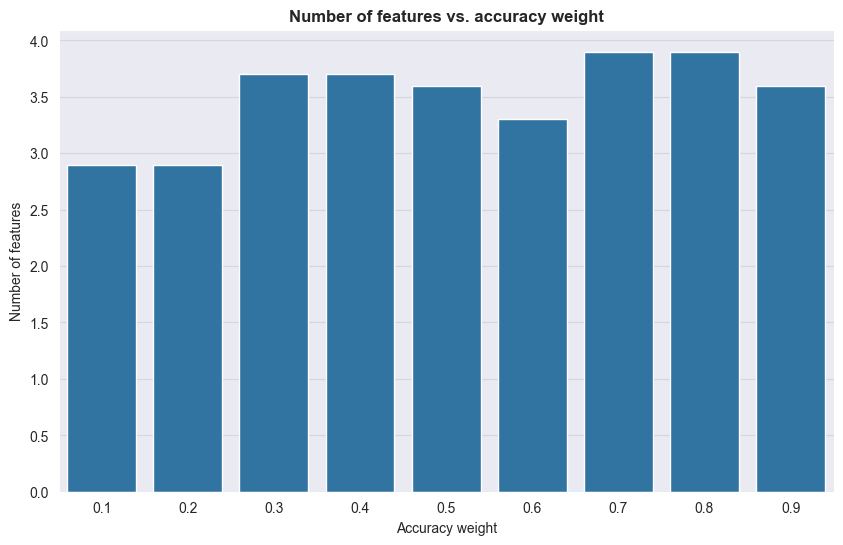

In [11]:
# Get last solution from discrete best solution history
train_df['NumFeatures'] = train_df['Discrete'].apply(lambda x: np.sum(x[-1]))

# Group by 'wa' and get mean of number of features
result_df = train_df.groupby('wa')['NumFeatures'].mean().reset_index()

# Sns bar plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Number of features vs. accuracy weight", fontweight='bold')

sns.barplot(ax=ax,
            data=result_df,
            x='wa',
            y='NumFeatures')

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xticks(range(len(result_df)))
ax.set_xticklabels(np.round(result_df["wa"], 1))

ax.set_xlabel("Accuracy weight")
ax.set_ylabel("Number of features")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

## Fitness convergence

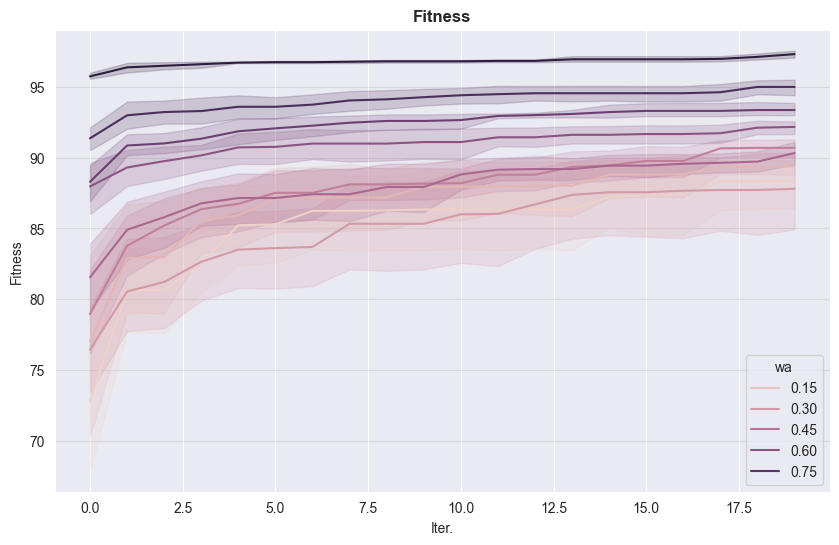

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=train_df,
             x="Iteration",
             y="Fitness",
             hue="wa",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

## Accuracy convergence

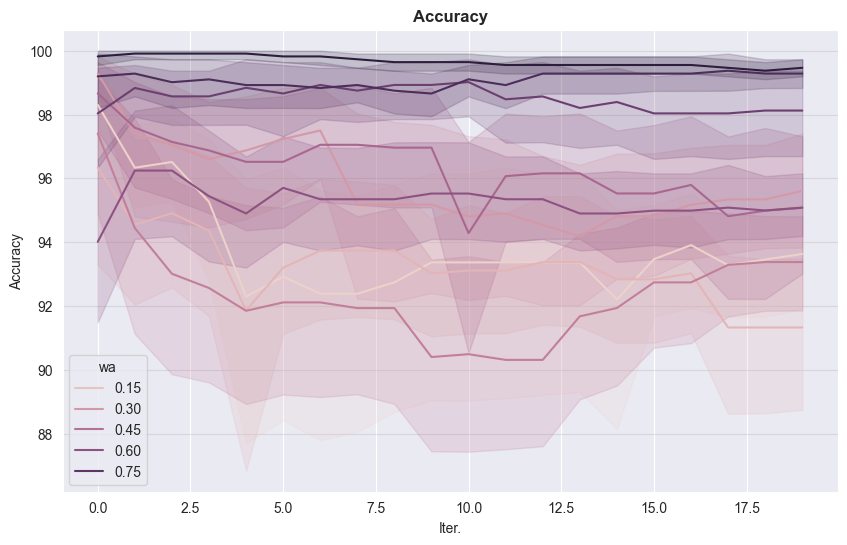

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Accuracy", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=train_df,
             x="Iteration",
             y="Accuracy",
             hue="wa",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Accuracy")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
mean_accuracy = np.round(np.mean(gsa_history_dict["accuracy_history"]), 4)
std_accuracy = np.round(np.std(gsa_history_dict["accuracy_history"]), 4)

print(f"Mean accuracy: {mean_accuracy} +/- {std_accuracy}")

mean_gamma = np.round(np.mean(gsa_history_dict["gamma_history"]), 4)
std_gamma = np.round(np.std(gsa_history_dict["gamma_history"]), 4)

print(f"Mean gamma: {mean_gamma} +/- {std_gamma}")

mean_c = np.round(np.mean(gsa_history_dict["c_history"]), 4)
std_c = np.round(np.std(gsa_history_dict["c_history"]), 4)

print(f"Mean C: {mean_c} +/- {std_c}")

mean_n_features = np.rint(np.mean(gsa_history_dict["n_features_history"])).astype(int)
std_n_features = np.rint(np.std(gsa_history_dict["n_features_history"])).astype(int)

print(f"Mean n_features: {mean_n_features} +/- {std_n_features}")

mean_execution_time = np.round(np.mean(gsa_history_dict["execution_time_history"]), 4)
std_execution_time = np.round(np.std(gsa_history_dict["execution_time_history"]), 4)

print(f"Mean execution time: {mean_execution_time} +/- {std_execution_time}")

mean_TP = np.rint(np.mean(gsa_history_dict["TP_history"])).astype(int)
std_TP = np.rint(np.std(gsa_history_dict["TP_history"])).astype(int)
mean_FP = np.rint(np.mean(gsa_history_dict["FP_history"])).astype(int)
std_FP = np.rint(np.std(gsa_history_dict["FP_history"])).astype(int)
mean_TN = np.rint(np.mean(gsa_history_dict["TN_history"])).astype(int)
std_TN = np.rint(np.std(gsa_history_dict["TN_history"])).astype(int)
mean_FN = np.rint(np.mean(gsa_history_dict["FN_history"])).astype(int)
std_FN = np.rint(np.std(gsa_history_dict["FN_history"])).astype(int)

In [ ]:
import datetime

save_path = "../data/output"
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

results = pd.DataFrame({"date": [date],
                        "dataset_name": [widget_opt.value],
                        "r_runs": [runs],
                        "n_pop": [population_size],
                        "n_iters": [iterations],
                        "chaotic_constant": [chaotic_constant],
                        "repair_solution": [repair_solution],
                        "execution_time": [mean_execution_time],
                        "execution_time_std": [std_execution_time],
                        "wa": [wa],
                        "wf": [wf],
                        "mean_accuracy": [mean_accuracy],
                        "std_accuracy": [std_accuracy],
                        "mean_gamma": [mean_gamma],
                        "std_gamma": [std_gamma],
                        "mean_c": [mean_c],
                        "std_c": [std_c],
                        "mean_n_features": [mean_n_features],
                        "std_n_features": [std_n_features],
                        "TP": [mean_TP],
                        "TP_std": [std_TP],
                        "FP": [mean_FP],
                        "FP_std": [std_FP],
                        "TN": [mean_TN],
                        "TN_std": [std_TN],
                        "FN": [mean_FN],
                        "FN_std": [std_FN]})

file = f"{save_path}/gsa_records.csv"
if os.path.exists(file):
    # Load dataframe and append new row
    df = pd.read_csv(file)
    df = pd.concat([df, results], axis=0, ignore_index=True)
    df.to_csv(file, index=False)
else: # Append row to existing file
    results.to_csv(file, index=False)